#  <span style="color:green">Tutorial - Graph SLAM</span>

This tutorial implements Graph SLAM to solve a small but non-trivial 2D localisation and mapping problem that uses landmark observations to optimise robotic poses. It is designed to develop your understanding of how graph SLAM front end and backends work, but for larger scale problems we recommend you use the `g2o-python` slam library. Understanding SLAM should make library documentation easier to follow.

The basic structure of the tutorial is as follows:

<img src="images/graphSLAM-front_back.png" alt="Cost Function" width="600px" align="center"/>

An analogy for graph SLAM is connecting many strings between poses and map locations (nodes). Each spring is defined by an edge constraint that has an individual equilibrium position (where it wants the nodes to be relative to each other) and stiffness (penalty for deviations from this equilibrium.  The graph SLAM algorithms attempts to find the nodes locations and poses that most relax the spings overall.  

<img src="images/spring_analogy.png" alt="Cost Function" width="600px" align="center"/>

We will build on some earlier libraries developed in the module (e.g., motion modelling, observations), and visualises what happens at different stages of the Graph SLAM algorithm.

In [2]:
# define some basic libraries we use
from matplotlib import pyplot as plt
from math_feeg6043 import Vector,Matrix,Identity,Transpose,Inverse,v2t,t2v,HomogeneousTransformation,polar2cartesian, cartesian2polar, gaussian
import numpy as np
import copy

# import mpmath
# mpmath.mp.dps = 32 #increases decimal precision

## Graph SLAM theory recap

Graphs consist of nodes and edges. We form nodes using the entries of the extended state vector (i.e., concatenated vector of $n$ robot poses and $l$ landmark locations) in the $e$-frame. The extended state vector has dimensions $[(3n+2l) \times 1]$.

\begin{equation}
\mathbf{x}_k=\begin{bmatrix}x_k\\ y_k\\ \gamma_k\end{bmatrix},\hspace{1cm}\mathbf{m}_i=\begin{bmatrix}x_i\\y_i\end{bmatrix},\hspace{1cm}\mathbf{X} = 
\begin{array}{rl}
\begin{bmatrix} 
\mathbf{x}_1\\
\vdots\\
\mathbf{x}_n\\
\mathbf{m}_{n+1}\\
\vdots\\
\mathbf{m}_{n+l}
\end{bmatrix}
\begin{matrix} 
&{\left.\begin{array}{@{}l@{}} \\ \\ \\ \end{array}\right\} \text{$n$ poses}}\hspace{1.6cm} \\
&{\left.\begin{array}{@{}l@{}} \\ \\ \\ \end{array}\right\} \text{$l$ landmarks}}\hspace{0.8cm}
\end{matrix}\end{array}
\end{equation}

Edges constrain the relative position of node pairs. Pose-pose pairs are constrained using the motion model $f(\cdot)$, covered in **A1.2**): 

\begin{align}
\mathbf{e}^T(\mathbf{x}_k) \boldsymbol{\Omega}_{R,k} \mathbf{e}(\mathbf{x}_k) &=&[\mathbf{x}_{k}-f(\mathbf{x}_{k-1},\mathbf{u}_{k})]^T \boldsymbol{\Omega}_{R,k}[\mathbf{x}_{k}-f(\mathbf{x}_{k-1},\mathbf{u}_{k})]
\end{align}

Pose-landmark pairs are constrained using the observation model $h(\cdot)$, covered in **A1.3**). 

\begin{align}
\mathbf{e}^T(\mathbf{z}_{ki}) \boldsymbol{\Omega}_{Q,ki} \mathbf{e}(\mathbf{z}_{ki})&=&[\mathbf{z}_{ki}-h(\mathbf{x}_{k},\mathbf{m}_{i})]^T \boldsymbol{\Omega}_{Q,ki}[\mathbf{z}_{ki}-h(\mathbf{x}_{k},\mathbf{m}_{i})]
\end{align}

These constraints are used to construct a $[(3n+2l) \times (3n+2l)]$ information matrix $\mathbf{H}$, and the $[(3n+2l) \times 1]$ infromation vector $\mathbf{b}$, which can be used to determine the necessary adjustments to the extended state vector in order to find the optimum configuration most effectively balances all edge constraints.

\begin{align}
\Delta\mathbf{X}=-\mathbf{H}^{-1}\mathbf{b}
\end{align}

## Visualising the Information form (what elements in a graph are influenced?)
Below, we develop functions to construct some simulated information vectors and matrices. Poses are always consecutively connected by motion. 

**Task 1:** Generate a minimal scenario with:
- 3 poses, [0,1,2]
- 2 landmarks [0,1]
- where pose 0 observes landmark 0 and pose 2 observes landmark 1

**Task 2:** Create the most helpful loop closure

In [3]:
def information_vector(n_pose,pose_size,n_landmark,landmark_size): 

    dim = n_pose*pose_size+n_landmark*landmark_size
    b =  Vector(dim)

    for n in range(n_pose+n_landmark):
        if n<n_pose: 
            i=n*pose_size
            b[i:i+pose_size] = node_intensity #nodes        
        else: 
            l = (n-n_pose)*landmark_size + (n_pose*pose_size)
            b[l:l+landmark_size] = node_intensity #nodes     
    return b

def information_matrix(n_pose,pose_size,n_landmark,landmark_size,observations): 

    dim = n_pose*pose_size+n_landmark*landmark_size
    H =  Matrix(dim,dim)
    
    for n in range(n_pose+n_landmark):
        if n<n_pose: #diagonal blocks representing poses
            i=n*pose_size
            H[i:i+pose_size,i:i+pose_size] = node_intensity #nodes        
        else: #diagonal blocks representing landmarks     
            l = (n-n_pose)*landmark_size + (n_pose*pose_size)
            H[l:l+landmark_size,l:l+landmark_size] = node_intensity #nodes 
    
    # motion connects adjascent poses
    for n in range(n_pose-1):    
        i = n*pose_size
        j = (n+1)*pose_size    
        H[i:i+pose_size,j:j+pose_size] = motion_intensity #nodes        
        H[j:j+pose_size,i:i+pose_size] = motion_intensity #nodes        
    
    for k in range(len(observations[1])):
        pose = observations[1][k] #kth pose (poses are second list entry)
        landmark = observations[3][k] #kth landmark (poses are fourth list entry)
        
        for n in range(n_pose):
            for m in range(n_landmark):
                if n == pose and m == landmark:                    
                    i=n*pose_size
                    l=n_pose*pose_size+m*landmark_size
                    H[i:i+pose_size,l:l+landmark_size] = observation_intensity #nodes   
                    H[l:l+landmark_size,i:i+pose_size] = observation_intensity #nodes  
    return H

n_pose = 3                            #Task
pose_size = 3                         #Task
n_landmark = 2                       #Task
landmark_size = 2                     #Task

# observation of landmark from pose
pose =[ 0,2 ]                             #Task
landmark = [1,1]                        #Task
observations = ['pose',pose,'landmark',landmark]

# set some intensity values for the visualisation
node_intensity = 3
motion_intensity = 1
observation_intensity = 2

print(observations)
b = information_vector(n_pose,pose_size,n_landmark,landmark_size)
H = information_matrix(n_pose,pose_size,n_landmark,landmark_size,observations)

print('b=',b)
print('H=',H)

['pose', [0, 2], 'landmark', [1, 1]]
b= [[3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]]
H= [[3. 3. 3. 1. 1. 1. 0. 0. 0. 0. 0. 2. 2.]
 [3. 3. 3. 1. 1. 1. 0. 0. 0. 0. 0. 2. 2.]
 [3. 3. 3. 1. 1. 1. 0. 0. 0. 0. 0. 2. 2.]
 [1. 1. 1. 3. 3. 3. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 3. 3. 3. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 3. 3. 3. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 3. 3. 3. 0. 0. 2. 2.]
 [0. 0. 0. 1. 1. 1. 3. 3. 3. 0. 0. 2. 2.]
 [0. 0. 0. 1. 1. 1. 3. 3. 3. 0. 0. 2. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 3. 0. 0.]
 [2. 2. 2. 0. 0. 0. 2. 2. 2. 0. 0. 3. 3.]
 [2. 2. 2. 0. 0. 0. 2. 2. 2. 0. 0. 3. 3.]]


Here we visualise the intensity and source of information vector and matrix. The larger the value of a entry, the darker it appears in the intensity plot. For the source, we use blue to indicate a node, green for motion and red for an observation constraint.
- can you explain 

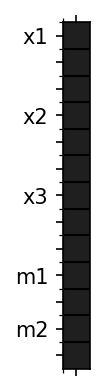

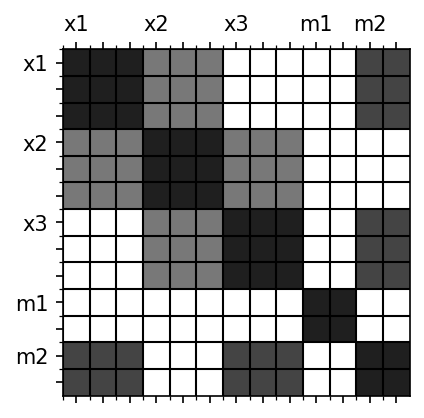

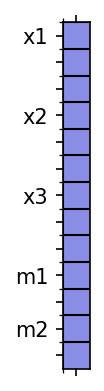

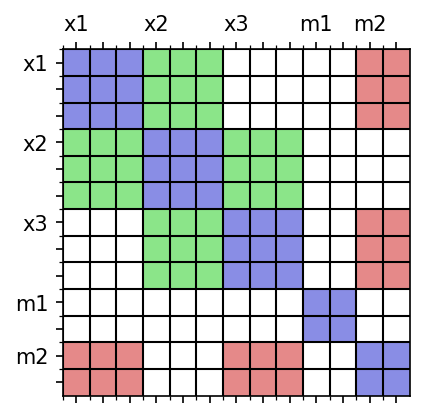

In [4]:
from plot_feeg6043 import show_information

show_information(b,n_pose,pose_size,n_landmark,landmark_size, display_type = 'intensity')
show_information(H,n_pose,pose_size,n_landmark,landmark_size, display_type = 'intensity')

show_information(b,n_pose,pose_size,n_landmark,landmark_size, display_type = 'source')
show_information(H,n_pose,pose_size,n_landmark,landmark_size, display_type = 'source')

The source visualisation also shows us where some information has changed compared to a previous vector of matrix. We show this by modifying b and H and visualising these again (compared to the originals). This can happen if new information about a constraint becomes available (e.g., reducing a graph to combine pose-landmark constraints into pose-pose constraints)
- If pose 0 and 2 observe landmark 1, what information matrix elements would change (for now we are not concerned how much they change by)

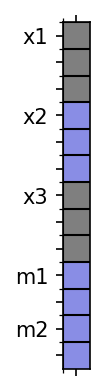

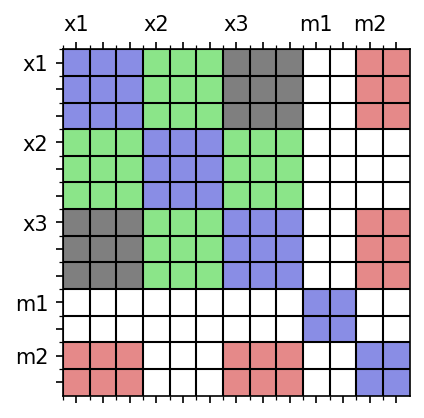

Note this is only illustrative with us manually changing values. Optimisation will automatically change these


In [5]:
pose_i = 0     #Task
pose_j = 2     #Task

i = pose_i*pose_size
j = pose_j*pose_size

b_=copy.copy(b)
b_[i:i+pose_size]+=0.1
b_[j:j+pose_size]+=0.1

H_=copy.copy(H)
H_[i:i+pose_size,j:j+pose_size]+=0.1
H_[j:j+pose_size,i:i+pose_size]+=0.1

show_information(b_,n_pose,pose_size,n_landmark,landmark_size, display_type = 'source', matrix_compare = b)  #Task
show_information(H_,n_pose,pose_size,n_landmark,landmark_size, display_type = 'source', matrix_compare = H)  #Task
print('Note this is only illustrative with us manually changing values. Optimisation will automatically change these')

## 1. Front end

The graph SLAM front end constructs the graph (i.e., the information vector and matrix) by applying and associating edge constraints to nodes. Motion edges connect consecutive pose-pose nodes, observation edges connect pose-landmark nodes. This needs to be done prior to optimisation with the back end, and also after optimisation to update the node and edge constraints.

## 1.1 Motion edge constraints (How to set the information values?)

We extend our motion and observation models from A1.2 and A1.3 to account for uncertainty. 

**Motion**: We use the motion model, where where $\sigma_{motion}$ is a $[3\times2]$ matrix relating pose elements to twist inputs.

<img src="images/robot_configurations.png" alt="Cost Function" width="600px" align="center"/>

$$\begin{bmatrix}\sigma_x\\ \sigma_y\\ \sigma_\gamma\end{bmatrix}= \sigma_{motion} \begin{bmatrix}v\\ w \end{bmatrix} = \begin{bmatrix}\sigma_{xv} & \sigma_{xw} \\ \sigma_{yv} & \sigma_{yx}\\ \sigma_{\gamma v} & \sigma_{\gamma w}\end{bmatrix} \begin{bmatrix}v\\ w \end{bmatrix}$$ 

EKF state outputs could also be used to generate the mean and uncertainty of each state. 

- Set controls (e.g., 0.1m/s, 5deg/s), and uncertainty model, and duration (e.g, dt=1, 5, 10) and check the relative motion and uncertainty is as you'd expect 
- What do you think the dots indicate in the plots?

3x2 motion noise model:
 [[1.00000000e-02 3.04617420e-06]
 [9.00000000e-02 2.74155678e-05]
 [1.00000000e-02 2.74155678e-05]] 

2x1 control vector:
 [[0.1       ]
 [0.08726646]] 



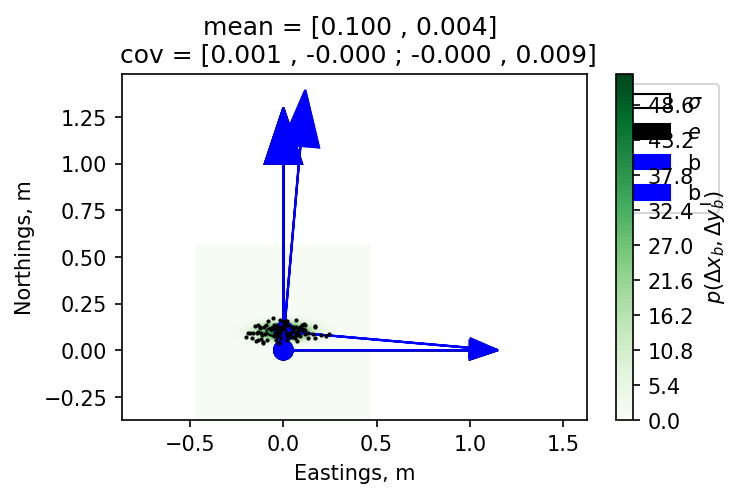

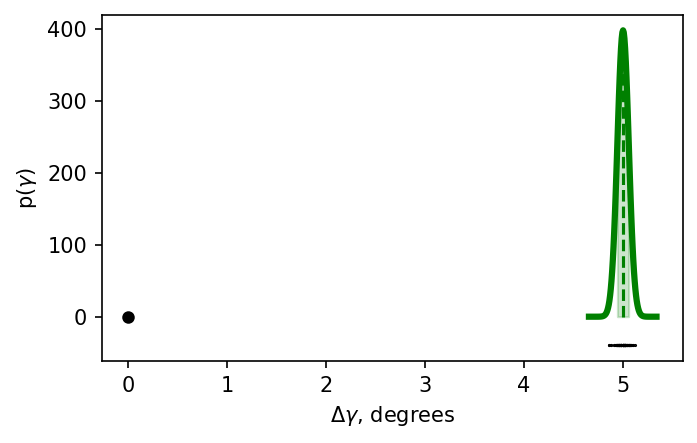

In [6]:
# define a function to plot uncertainties
from plot_feeg6043 import plot_2dframe, sigma_contour        
from model_feeg6043 import rigid_body_kinematics
from plot_feeg6043 import plot_motion_uncertainty

#Motion model linear noise due to v and w
sigma_motion=Matrix(3,2)
sigma_motion[0,0]= 0.1**2 # impact of v linear velocity on x           #Task
sigma_motion[0,1]= np.deg2rad(0.1)**2 # impact of w angular velocity on x
sigma_motion[1,0]=0.3**2 # impact of v linear velocity on y
sigma_motion[1,1]=np.deg2rad(0.3)**2 # impact of w angular velocity on y
sigma_motion[2,0]=0.1**2 # impact of v linear velocity on gamma
sigma_motion[2,1]=np.deg2rad(0.3)**2 # impact of w angular velocity on gamma
print('3x2 motion noise model:\n',sigma_motion,'\n')

# Control, acts on the moving frame
u = Vector(2); 
u[0] = 0.1 #surge velocity m/s                                        #Task
u[1] = np.deg2rad( 5 ) #rotational velocity 5 deg/s
print('2x1 control vector:\n',u,'\n')

# plot uncertainty in relative motion and overlay n samples
plot_motion_uncertainty(sigma_motion,u,dt=1,n=100)                  #Task

Model and visualise uncertain motion. 
- Do you expect the ground truth or the modelled motion to change with random noise sampling?
- Try re-running the motion. Can you explain some positions changes each time while others don't?

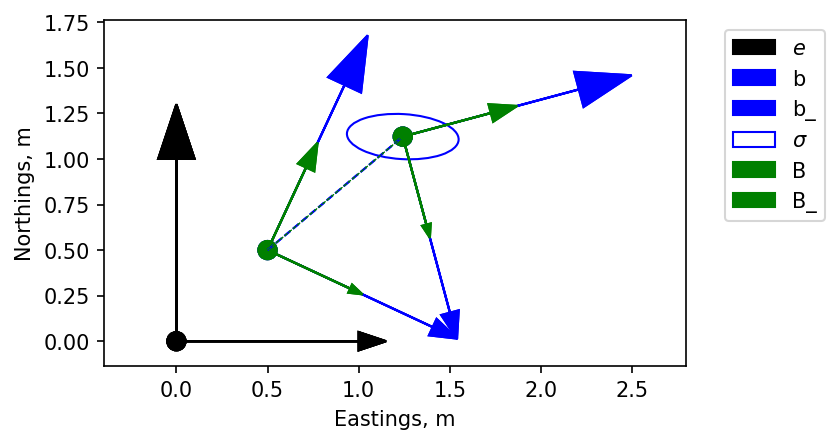

In [7]:
################################## initial pose #################################
# initial state
p = Vector(3); 
p[0] = 0.5 #Northings
p[1] = 0.5 #Eastings
p[2] = np.deg2rad(25) #Heading (rad)

# Make homogeneous matrix for initial poses
X_i = HomogeneousTransformation(p[0:2], p[2]) #Task

# initial state as the ground truth to visualise true motion under noise
p_gt = p
X_igt = HomogeneousTransformation(p_gt[0:2], p_gt[2]) #Task
####################################################################################################

################################## initial uncertainty #################################
sigma_xy=Matrix(3,3)

# Store mean and covariance to plot uncertainty
x = p[0:2].tolist()    
s = sigma_xy[0:2,0:2].tolist()
e_i=sigma_contour([x[1],x[0]],[[s[1][1],s[1][0]],[s[0][1],s[0][0]]],'b')
####################################################################################################

############################# motion model with earlier control and uncertainty model############################
p, sigma_xy, dp_, p_gt =  rigid_body_kinematics(p,u,dt=10,mu_gt=p_gt,sigma_motion=sigma_motion, sigma_xy= sigma_xy)
#################################################################################################################

################# pose after motion ############################
# Make homogeneous matrix
X_j = HomogeneousTransformation( p[0:2], p[2]) #Task

#to plot uncertainty, centre and major axes
x = p[0:2].tolist()    
s = sigma_xy[0:2,0:2].tolist()
e_j=sigma_contour([x[1],x[0]],[[s[1][1],s[1][0]],[s[0][1],s[0][0]]],'b')

# ground truth state after motion
X_jgt = HomogeneousTransformation(p[0:2], p[2]) #Task
####################################################################################################

################# plot the model (with noise) and ground truth solution (no noise) #################
fig = plt.figure()
ax = plt.subplot(111, aspect='equal')

# motion with noise
cf=plot_2dframe(['pose','b','b_'],[X_i.H,X_j.H],True)
cf._fixed_frame()
cf._pose()        

# uncertainty before motion
e_i.set_facecolor('none')
ax.add_patch(e_i)

# uncertainty after motion
e_j.set_facecolor('none')
ax.add_patch(e_j)

# ground truth motion
cf=plot_2dframe(['pose_gt','B','B_'],[X_igt.H,X_jgt.H],True)
cf._fixed_frame()
cf._pose()

## 1.2 Observation edge constraints (How to set the information values?)

We use the observation model, where where $\sigma_{observation}$ is a $[2\times2]$ matrix relating landmark position to the range and bearing of the lidar measurement.

<img src="images/range_bearing.png" alt="Cost Function" width="600px" align="center"/>

$$\begin{bmatrix}\sigma_x\\ \sigma_y\end{bmatrix}= \sigma_{observation} \begin{bmatrix}r\\ \theta \end{bmatrix} = \begin{bmatrix}\sigma_{xr} & \sigma_{x\theta} \\ \sigma_{yr} & \sigma_{y\theta}\end{bmatrix} \begin{bmatrix}r\\ \theta \end{bmatrix}$$ 

Below we implement a model with noise proportional to range but independent of bearing.

- Set range, bearing and uncertainty model parameters. Does the uncertainty behave as you expect?

2x2 measurement noise model:
 [[0.01       0.        ]
 [0.00761544 0.        ]] 



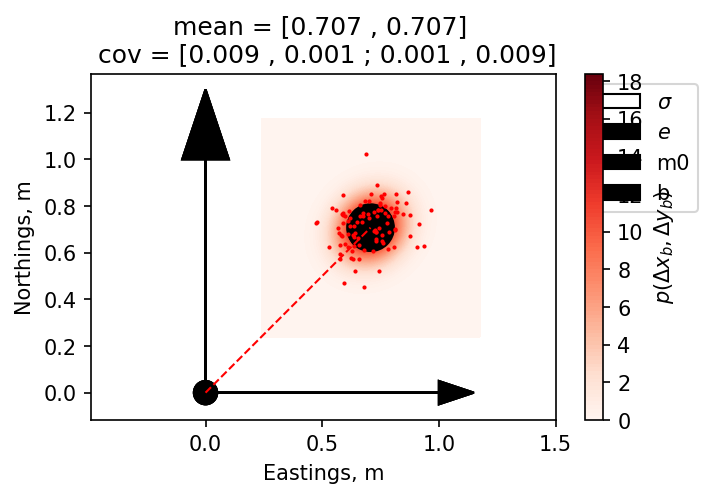

In [8]:
from model_feeg6043 import RangeAngleKinematics
from plot_feeg6043 import plot_observation_uncertainty, show_observation

#########observation model linear noise with range###############
sigma_observe = Matrix(2,2)
sigma_observe[0,0] = 0.1**2 #10% of range                             #Task
sigma_observe[0,1] = 0                                              #Task
sigma_observe[1,0] = np.deg2rad(5) **2 #5 degree per metre range                #Task
sigma_observe[1,1] = 0                                              #Task
print('2x2 measurement noise model:\n',sigma_observe,'\n')
#################################################################

z = Vector(2)
z[0] = 1 #range                                                        #Task
z[1] = np.deg2rad( 45 ) #bearing                                         #Task

# plot the uncertainty
plot_observation_uncertainty(sigma_observe,z,n=100)                     #Task

Determine the uncertain observation for a given robot pose and landmark location using an extended observation model (A1.3). 
- Establish a Lidar observation model with the FOV as 360degrees over a range of 0.1 to 5m and the lidar coinciding with the pose reference of the robot

3x1 state vector:
 [[ 0.5       ]
 [-0.5       ]
 [ 2.53072742]] 

2x1 landmark location:
 [[0.5]
 [2. ]] 

*******************************************************************************************
Sensor located at: [0.] [0.] m offset, at angle: 0.0 deg to the body
Measurement range is between: [0.1, 5] m
Scanning field of view is: 360.0 deg
Number of beams per scan is: 30
*******************************************************************************************


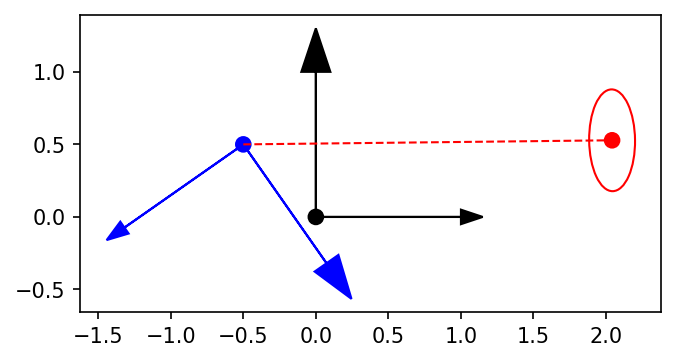

In [9]:
    
######################## Set the robot pose b in the e frame ##################
p_eb = Vector(3); 
p_eb[0] = 0.5 #Northings
p_eb[1] = -0.5 #Eastings
p_eb[2] = np.deg2rad(145) #Heading (rad)
print('3x1 state vector:\n',p_eb,'\n')
H_eb = HomogeneousTransformation(p_eb[0:2],p_eb[2])
#############################################################################

######################## Set the map landmark in the e frame ##################
t_em = Vector(2)
t_em[0] = 0.5 #Northings
t_em[1] = 2 #Eastings
print('2x1 landmark location:\n',t_em,'\n')
#############################################################################


######################## Observation model ##################
# locate lidar on robot (keep it simple)
x_bl = 0; y_bl = 0 # Task
t_bl = Vector(2)
t_bl[0] = x_bl
t_bl[1] = y_bl
H_bl = HomogeneousTransformation(t_bl, 0)   # Task
# use Class from A1.3
simple_observation_model = RangeAngleKinematics(x_bl, y_bl, distance_range = [0.1, 5], scan_fov = np.deg2rad( 360 ))    # Task
z_lm, sigma_rtheta, t_lm, sigma_xy = simple_observation_model.loc_to_rangeangle(p_eb, t_em, sigma_observe = sigma_observe)
#############################################################################

######################## Plot observation ##################
fig = plt.figure()
ax = plt.subplot(111, aspect='equal')
show_observation(H_eb,t2v( H_bl.H@v2t(t_lm)),sigma_xy,'m0',ax)      # Task

## 1.3 Data association (i.e., Graph construction)
We can now put these together to construct a graph. Essentially, this means populating the information vector $\mathbf{b}$ and information matrix $\mathbf{H}$ using the individual edge constraint. The front end basically does the data association book keeping to make sure the edge constraints apply to the correct part of $\mathbf{b}$ and $\mathbf{H}$. 

Refer to B2.2 of the notes for how to determine the actual Jacobians. A summary is provided below.

<img src="images/single_constraint_information_vector_matrix.png" alt="Cost Function" width="600px" align="center"/>


**Pose-Pose Constraints:**

Two consecutive poses $i$ and $j$ and their relative spatial relationship can be described as:


\begin{align}
\mathbf{x}_i&=&\begin{bmatrix} x_i\\ y_i\\  \gamma_i\end{bmatrix} = \begin{bmatrix} \mathbf{t}_{ei}\\  \gamma_i\end{bmatrix}, \hspace{0.5cm}
\mathbf{x}_j=\begin{bmatrix} x_j\\ y_j\\  \gamma_j\end{bmatrix} = \begin{bmatrix} \mathbf{t}_{ej}\\  \gamma_j\end{bmatrix}, \hspace{0.5cm}
\mathbf{x}'_{ij}&=&\begin{bmatrix} x_{ij}\\ y_{ij}\\  \gamma_{ij}\end{bmatrix} = \begin{bmatrix} \mathbf{t}_{ij}\\ \gamma_{ij}\end{bmatrix}
\end{align}

where $\mathbf{x}'_{ij}$ is the offset we compute through out motion model. This offset between poses $i$ and $j$ can be expressed:

\begin{align}
\mathbf{H}_{ij}(v2t(\mathbf{e}_{ij}))= \mathbf{H}_{ie}\mathbf{H}_{ej}
\end{align}

The left side is the offset we obtain from our motion model, where $\mathbf{e}_{ij}$ represents some unknown error we want to minimise. The right is the offset we predict from the current poses estimates (recall the sub-script cancellation rule from A1.1). Rearranging and expanding gives:

\begin{align}
\mathbf{e}_{ij} &=& \begin{bmatrix} \mathbf{R}^T_{ij}(\mathbf{R}^T_{ei} (\mathbf{t}_{ej} - \mathbf{t}_{ei}) - 
\mathbf{t}_{ij})\\ 
  \gamma_{j}-\gamma_{i}-\gamma_{ij}\end{bmatrix} =
\begin{bmatrix} \Delta \mathbf{t}\\ \Delta \gamma\end{bmatrix}
\end{align}

The Jacobians of the error function can then be derived as follows:

\begin{align}
\mathbf{A}_{ij} &=& \dfrac{\partial \mathbf{e}_{ij}}{\partial \mathbf{x}_i} =
 \begin{bmatrix}
\dfrac{\partial\Delta \mathbf{t}}{\partial \mathbf{t}_{ei}} & \dfrac{\partial\Delta \mathbf{t}}{\partial \gamma_i}\\
\dfrac{\partial\Delta \gamma}{\partial \mathbf{t}_{ei}} & \dfrac{\partial\Delta \gamma}{\partial \gamma_i}\\
\end{bmatrix} = \begin{bmatrix}
-\mathbf{R}^T_{ij}\mathbf{R}^T_{ei} & \mathbf{R}^T_{ij}\dfrac{\partial\mathbf{R}^T_{ei}}{\partial \gamma_i}(\mathbf{t}_{ej}-\mathbf{t}_{ei})\\
0 & -1
\end{bmatrix}\\
\mathbf{B}_{ij} &=& \dfrac{\partial \mathbf{e}_{ij}}{\partial \mathbf{x}_j} =
 \begin{bmatrix}
\dfrac{\partial\Delta \mathbf{t}}{\partial \mathbf{t}_{ej}} & \dfrac{\partial\Delta \mathbf{t}}{\partial \gamma_j}\\
\dfrac{\partial\Delta \gamma}{\partial \mathbf{t}_{ej}} & \dfrac{\partial\Delta \gamma}{\partial \gamma_j}\\
\end{bmatrix} = \begin{bmatrix}
\mathbf{R}^T_{ij}\mathbf{R}^T_{ei} & 0\\
0 & 1
\end{bmatrix}\\
\end{align}

for $\mathbf{x}_i = [x_i, y_i, \gamma_i]^T$ and $\mathbf{x}_j = [x_j, y_j,  \gamma_j]^T$ where

\begin{align}
\dfrac{\partial\mathbf{R}^T_{ei}}{\partial \gamma_i}=\begin{bmatrix}
-\sin{\gamma_i} & \cos{\gamma_i}\\
-\cos{\gamma_i}  & -\sin{\gamma_i}
\end{bmatrix}
\end{align}


Both Jacobians are $[3\times 3]$ matrices.

**Pose-Landmark Constraints:**

A pose $i$ observing landmark $l$ and their relative spatial relatioship can be described as:

\begin{align}
\mathbf{x}_i=\begin{bmatrix} x_i\\ y_i\\  \gamma_i\end{bmatrix}=\begin{bmatrix} \mathbf{t}_{ei}\\  \gamma_i\end{bmatrix}, \hspace{0.5cm}
\mathbf{m}_l=\mathbf{m}_{el}=\begin{bmatrix} x_l\\ y_l\\ \end{bmatrix}, \hspace{0.5cm}\mathbf{z}_{il}&=&\begin{bmatrix} x_{il}\\ y_{il}\end{bmatrix}
\end{align}


where subscript $e$ in $\mathbf{m}_{el}$ is because landmark coordinates are in the environment frame. The observation $\mathbf{z}_{il}$ is the measurement of where the landmark was seen by robot's sensors. This can also be expressed in terms of the homogeneous transformation between pose $i$ and landmark $l$ as:

\begin{align}
\begin{bmatrix}\mathbf{z}_{il}\\ 1\end{bmatrix}+\begin{bmatrix}\mathbf{e}_{il}\\1\end{bmatrix}= \mathbf{H}_{ie}\begin{bmatrix}\mathbf{m}_{el}\\ 1\end{bmatrix}
\end{align}

where $\mathbf{e}_{il}$ is the unknown error that we want to minimise:

\begin{align}
\mathbf{e}_{il} = \mathbf{R}^T_{ei}(\mathbf{m}_{el} - \mathbf{t}_{ei}) - \mathbf{z}_{il}
\end{align}


The Jacobians of the error function can then be derived as follows:

\begin{align}
\mathbf{A}_{il} &=& \dfrac{\partial \mathbf{e}_{il}}{\partial \mathbf{x}_i} =
\begin{bmatrix}
\dfrac{\partial\mathbf{e}_{il}}{\partial \mathbf{t}_{ei}} & \dfrac{\partial\mathbf{e}_{il}}{\partial \gamma_{i}}
\end{bmatrix} = \begin{bmatrix}
-\mathbf{R}^T_{i} & \dfrac{\partial\mathbf{R}^T_{ei}}{\partial \gamma_i}(\mathbf{m}_{el}-\mathbf{t}_{ei})
\end{bmatrix}\\
\mathbf{B}_{il} &=& \dfrac{\partial \mathbf{e}_{il}}{\partial \mathbf{m}_{el}} = \mathbf{R}^T_{i}
\end{align}

The Jacobian $A_{il}$ is a $[2\times 3]$  matrix and $B_{il}$ is a $[2\times 2]$  matrix.

In [10]:
from plot_feeg6043 import plot_graph
from model_feeg6043 import graphslam_frontend

class graphslam_frontend:
    """
    This class implements the graph SLAM frontend
    
    Functions construct the graph information by:
    - Register elements of the extended state vector as poses or landmarks
    - Register motion constraints between pose-pose pairs based in external model generated covariances 
    - Register observation constraints between pose-landmark pairs based on external model generated covariances
    
    Attributes are:
        pose: [3n x 1] vector of floats
                n time-consecutive poses in the e-frame lined up one after another (x-northings, y-easting, g-heading), each with
                    [x y g]^T
        pose_covariance: [3n x 3] matrix of floats
                n time-consecutive pose covariance matrices lined up one after another, each with 
                    [s_xx s_xy s_xg; s_yx s_yy s_yg; s_gx s_gy s_gg] 
        landmark: [2m x 1] vector of floats
                l unique landmarks coordinates in order of observation lined up one after another, each with
                    [x y]^T
        landmark_covariance: [2m x 2] matrix of floats
                l observation-consecutive landmark covariance matrices lined up one after another, each with
                [s_xx s_xy; s_yx s_yy]  
        edge: ['string', int, int, float] mixed list
                Data association where the 'string' indicates the type of constraint, followed by the nodes connected by the edge and the float is the value of the constraint 
        pose_id: integer pointer to corresponding pose entry
        landmark_id_array: [] integer array logging order of landmark observations
        observation_id: integer pointer to corresponding observation entry
        b: [3n+2m x 1] vector of floats 
                information_vector
        H: 3n+2m x 3n+2m] matrix of floats 
                information matrix
        sigma_anchor: [3 x 3] matrix of floats
                Constraint on the initial pose
        residual: float used during optmisation            
        unique_landmark: [] integer list of unique landmarks
        sigma: Covariance matrix used during Jacobian calculation for determining b and H
        information_vector: [3n+2m x 1] vector of floats #is this needed (BLAIR)
        state_vector: [3n+2m x 1] vector of floats #is this needed (BLAIR)
        information_graph: [3n+2m x 3n+2m] matrix of floats #is this needed (BLAIR)
        n: int number of poses
        m: int number of landmarks
        e: int number of edges

    Functions:

        Front end functions:
        
        anchor(self,sigma): 
            Sets initial pose constraint, takes a 
        observation(self,m,sigma,landmark_id,z):  
            Register a pose (p) to landmark (m) observation (z) as a graph edge constraint with relative covariance
        motion(self, p, sigma, z, final = False):
            Register a consecutive poses (p, p_) as a motion graph edge constraint with relative covariance
        construct_graph(self, visualise_flag = False, update = graph):  
            Populates the information vector b and matrix H based on the observation and motion data associations
        _Jacobian(self,edge_type,x_i,x_j,z_ij = None, visualise_flag = False):  
            Uses the motion and landmark constraints to determine the Jacobian elements and error the 
            returns e,A,B            

    """
    def __init__(self, graph = None):
        # Note that the class implementation ONLY stores the translation vector and
        # rotation angle. The rotation matrix and homogeneous transformation matrix are
        # computed on the fly.
        if graph != None:
            
            self.pose = graph.pose            
            self.pose_covariance = graph.pose_covariance
            self.landmark = graph.landmark
            self.landmark_covariance = graph.landmark_covariance
            self.edge = graph.edge
            self.state_vector = graph.state_vector
            self.pose_id = graph.pose_id
            self.landmark_id_array = graph.landmark_id_array
            self.observation_id = graph.observation_id
            self.b = graph.b
            self.H = graph.H
            self.sigma_anchor = graph.sigma_anchor
            self.residual = graph.residual
            self.unique_landmark = graph.unique_landmark
            self.sigma = graph.sigma
            self.dx = graph.dx
            
            self.n = graph.n #number of poses
            self.m = graph.m #number of unique landmarks
            self.e = graph.e #number of edge
            
        else:
            self.pose = []
            self.pose_covariance = []
            self.landmark = []
            self.landmark_covariance = []
            self.edge = []        
            self.state_vector = None        
            self.pose_id = 0
            self.landmark_id_array = []
            self.observation_id = 0        
            self.b = None
            self.H = None
            self.sigma_anchor = None      
            self.residual = None
            self.unique_landmark = []
            self.sigma = []
            self.dx = None
            
            self.n = 0 #number of poses
            self.m = 0 #number of unique landmarks
            self.e = 0 #number of edge
    
    def anchor(self,sigma):
        self.sigma_anchor = sigma
        
    def observation(self,m,sigma,landmark_id,z):        
        self.landmark.append(copy.copy(m))          # this is need to avoid deep copy behaviour in python
        self.landmark_covariance.append(copy.copy(sigma))
        self.edge.append(['landmark', self.pose_id, self.observation_id, z])     # Task
        self.landmark_id_array.append(landmark_id)
        self.observation_id += 1        
        
    def motion(self, p,sigma, z, final = False):        
        if final == False:
            self.edge.append(['motion', self.pose_id, self.pose_id+1, z])    # Task
            self.pose_id += 1                            
        self.pose.append(copy.copy(p))   
        self.pose_covariance.append(copy.copy(sigma))          
        
    def construct_graph(self,visualise_flag = False):        
        print('Constructing graph with:')   
                    
        unique_landmark = []
        for n in range(len(self.landmark_id_array)):
            if self.landmark_id_array[n] not in unique_landmark:
                unique_landmark.append(self.landmark_id_array[n])
        self.unique_landmark=sorted(unique_landmark)

        self.n = len(self.pose)
        self.m = len(unique_landmark)
        print(self.n+self.m,'nodes')
        print('(',self.n,':poses, ',self.m,':landmark)')
        self.e = len(self.edge)
        print(self.e,'edge')
       
        self.state_vector = Vector(3*self.n+2*self.m)        
        
        self.b = Vector(3*self.n+2*self.m)        
        self.H = Matrix(3*self.n+2*self.m,3*self.n+2*self.m)
                
        #constrain the initial location (this would be our initial aruco tag measurements uncertainty)
        self.H[0:3,0:3] = Inverse(self.sigma_anchor )   # Task 

        # work through the edges to construct b and H
        for k in range(self.e):
                        
            if visualise_flag == True: print('Edge',self.edge[k])
            
            edge_type=self.edge[k][0]
            i=self.edge[k][1]
            j=self.edge[k][2]    
        
            if edge_type == 'motion':
                #point to correct location in the extended state vector
                self.state_vector[3*i:3*i+3]=self.pose[i]
                self.state_vector[3*j:3*j+3]=self.pose[j]
                # associate the constraint
                z_ij =self.edge[k][ 3 ]     # Task

                # construct the information vector and matrix using the motion Jacobian                
                e_ij,A_ij,self.bij = self._Jacobian(edge_type,self.state_vector[3*i:3*i+3],self.state_vector[3*j:3*j+3],z_ij,visualise_flag)
                
                if visualise_flag == True:
                    print('self.pose[i]',self.pose[i])
                    print('self.pose[j]',self.pose[j])                
                    print('z_ij',z_ij)         
                    print('e_ij',e_ij)
                    print('A_ij',A_ij)         
                    print('self.bij',self.bij)
                    
                sigma_ij = self.pose_covariance[j]-self.pose_covariance[i]#-

                # populate information vector and matrix
                self.b[3*i:3*i+3] += (e_ij.T@Inverse(sigma_ij)@A_ij).T
                self.b[3*j:3*j+3] += (e_ij.T@Inverse(sigma_ij)@self.bij).T              
               
                self.H[3*i:3*i+3,3*i:3*i+3] += A_ij.T@Inverse(sigma_ij)@A_ij
                self.H[3*i:3*i+3,3*j:3*j+3] += A_ij.T@Inverse(sigma_ij)@self.bij                
                self.H[3*j:3*j+3,3*i:3*i+3] += self.bij.T@Inverse(sigma_ij)@A_ij
                self.H[3*j:3*j+3,3*j:3*j+3] += self.bij.T@Inverse(sigma_ij)@self.bij     

            if edge_type == 'landmark':        
                #point to correct location in the extended state vector
                self.state_vector[3*i:3*i+3]=self.pose[i]                                
                l = 3*self.n+2*self.unique_landmark.index(self.landmark_id_array[j])  
                # associate the constraint
                z_il =self.edge[k][ 3 ]    # Task
                
                # construct the information vector and matrix using the observation Jacobian                      
                if np.all(self.state_vector[l:l+2]) == 0.0: 
                    self.state_vector[l:l+2]=copy.copy(self.landmark[j])
                    e_il,A_il,self.bil = self._Jacobian(edge_type,self.state_vector[3*i:3*i+3],self.state_vector[l:l+2],z_il)
                    
                else:                    
                    # deals with the loop closure by keeping first landmark position but using new landmark observation constraint to isolate inconsistency
                    e_il,A_il,self.bil = self._Jacobian(edge_type,self.state_vector[3*i:3*i+3],self.state_vector[l:l+2],z_il,visualise_flag)

                if visualise_flag == True:
                    print('self.pose[i]  ',self.pose[i]  )
                    print('self.landmark[j]  ',self.landmark[j]  )                
                    print('self.state_vector[l]',self.state_vector[l:l+2])
                    print('z_il',z_il)  
                    print('e_il',e_il)
                    print('A_il',A_il)                
                    print('self.bil',self.bil)
                
                sigma_il = self.landmark_covariance[j][0:2,0:2]
                
                self.b[3*i:3*i+3] += (e_il.T@Inverse(sigma_il)@A_il).T
                self.b[l:l+2] += (e_il.T@Inverse(sigma_il)@self.bil).T                                            

                self.H[3*i:3*i+3,3*i:3*i+3] += A_il.T@Inverse(sigma_il)@A_il
                self.H[3*i:3*i+3,l:l+2] += A_il.T@Inverse(sigma_il)@self.bil
                self.H[l:l+2,3*i:3*i+3] += self.bil.T@Inverse(sigma_il)@A_il                    
                self.H[l:l+2,l:l+2] += self.bil.T@Inverse(sigma_il)@self.bil  
                
            if visualise_flag == True:
                print('Information vector (b)')
                show_information(self.b,self.n,3,self.m,2)                
                print('Information matrix (H)')                        
                show_information(self.H,self.n,3,self.m,2)      
                
    def _Jacobian(self,edge_type,x_i,x_j,z_ij = None, visualise_flag = False):                             
        if edge_type == 'motion':
            
            X_i=HomogeneousTransformation(x_i[0:2], x_i[2])     # Task  (prev pose)
            X_j=HomogeneousTransformation(x_j[0:2] ,x_j[2])     # Task    (next pose)                           

            # this is for the first instance only and cannot be itterated over
            Z_ij=HomogeneousTransformation(z_ij[0:2],z_ij[2])            # how much it thinks its moved
            
            e_ij = Vector(3) # 
            e_ij[0:2] = Z_ij.R.T@(X_i.R.T@( X_j.t-X_i.t) - Z_ij.t)   # 
            e_ij[2] = (X_j.gamma -  X_i.gamma - Z_ij.gamma + np.pi) % (2 * np.pi ) - np.pi     # Task   
            
            if visualise_flag == True:
                print('e_ij[0:2]',e_ij[0:2])
                print('(X_i.R.T@(X_j.t-X_i.t)',X_i.R.T@(X_j.t-X_i.t))
                print('Z_ij.t',Z_ij.t)            
                print('Z_ij.R.T',Z_ij.R.T)
                print('e_ij[2]',e_ij[2])  
                print('X_j.gamma,X_i.gamma,Z_ij.gamma',X_j.gamma,X_i.gamma,Z_ij.gamma)
            
            dR_i_dg_i = Matrix(2,2)
            dR_i_dg_i[0,0] = -np.sin(X_i.gamma)
            dR_i_dg_i[1,1] = -np.sin(X_i.gamma)    # Task   
            dR_i_dg_i[0,1] = -np.cos(X_i.gamma)
            dR_i_dg_i[1,0] = np.cos(X_i.gamma)    # Task   

            A_ij = Matrix(3,3)            
            A_ij[0:2,0:2] = Z_ij.R.T @ X_i.R.T     # Task
            A_ij[0:2,2:3] = Z_ij.R.T@dR_i_dg_i.T@(X_j.t-X_i.t)
            A_ij[2,2] = -1        # Task
            
            self.bij = Matrix(3,3)
            self.bij[0:2,0:2] = Z_ij.R.T@X_i.R.T     # Task
            self.bij[2,2] = 1
            
            e=e_ij            
            A=A_ij
            B=self.bij            
            
        if edge_type == 'landmark':            

            X_i=HomogeneousTransformation(x_i[0:2],x_i[2])
            
            # takes first observation at the actual position
            x_l = x_j
            X_l=HomogeneousTransformation(x_l,0)            

            # uses new observation to calculate the observation error
            z_il = z_ij
            Z_il=HomogeneousTransformation(z_il,0)            
             
            # z_il is based on the new observation whereas x_l is based on original position
            # if only 1 observation is made then z_il is consistent with x_i  x_l
            e_il = Vector(3)            
            e_il = X_i.R.T@(X_l.t-X_i.t) - Z_il.t  # Task

            if visualise_flag == True:
                print('e_il',e_il)
                print('(X_i.R.T@(X_l.t-X_i.t)',X_i.R.T@(X_l.t-X_i.t))
                print('Z_il.t',Z_il.t)            
            
            dR_i_d_g_i = Matrix(2,2)
            dR_i_d_g_i[0,0] = -np.sin(X_i.gamma)
            dR_i_d_g_i[1,1] = -np.sin(X_i.gamma)                     # Task
            dR_i_d_g_i[0,1] = -np.cos(X_i.gamma)                     # Task
            dR_i_d_g_i[1,0] = np.cos(X_i.gamma)            

            A_il = Matrix(2,3)            
            A_il[0:2,0:2] = -X_i.R.T   # Task ??? NEGATIVE
            A_il[0:2,2:3] = dR_i_d_g_i.T@(X_l.t-X_i.t)   # Task
            
            self.bil = Matrix(2,2)
            self.bil = X_i.R.T # Task
            
            e=e_il
            A=A_il
            B=self.bil            
            
        return e,A,B

Implement a minimal example (see below) to construct and visualise a graph front end using the motion and observation models. 
<img src="images/graph_construction.png" alt="Cost Function" width="800px" align="center"/>

Assume landmark IDs are known (e.g., via classification)




In [20]:
################## initial pose ##################
p = Vector(3); 
p[0] = 0.5 #Northings
p[1] = 0.5 #Eastings
p[2] = np.deg2rad(25) #Heading (rad)
print('3x1 state vector:\n',p,'\n')

# anchor constraint, matrix must be invertable
sigma = Matrix(3,3) 
sigma[0,0]=0.1
sigma[0,1]=0.01
sigma[1,0]=0.01
sigma[1,1]=0.1
sigma[0,2]=0.01
sigma[1,2]=0.01
sigma[2,0]=0.01
sigma[2,1]=0.01
sigma[2,2]=0.1

# track ground truth location and path
p_gt=p
p_gt_path = []

# placeholder for relative motion
dp = Vector(3)
##################################################

####### Control, acts on the moving frame ########
u = Vector(2); 
u[0] = 0.2 #surge velocity
u[1] = np.deg2rad(5) #angluar velocity
print('2x1 control vector:\n',u,'\n')
##################################################

############## Actual landmarks  ################
em = Vector(2)
H_em = HomogeneousTransformation(em,0)

m_e0 = Vector(2)
m_e0[0] = -0
m_e0[1] = 2

m_e1 = Vector(2)
m_e1[0] = 2
m_e1[1] = 5

m_e2 = Vector(2)
m_e2[0] = 1.0
m_e2[1] = 5.5
################################################## 

############ Simulation parameters  ##############
#timestep and limits
t_start = 0
t_end = 30.1
dt = 10
################################################## 

################ initialise graph ################
print('Start graph data association')
graph = graphslam_frontend()
graph.anchor(sigma)

for t in np.arange(t_start, t_end, dt):
    print('************* Loop t=',t,'s ********************')

    # log ground truth
    p_gt_path.append(p_gt)

    # homogeneous matrices
    H_ebgt = HomogeneousTransformation( p_gt[0:2], p_gt[2])    # Task       
    H_eb = HomogeneousTransformation( p[0:2], p[2] )    # Task       


    # handle where a landmark observation is made - landmark id is known
    if t == 0:         
        # makes observation
        landmark_id = 0
        z_lm, sigma_rtheta, t_lm, sigma_xy = simple_observation_model.loc_to_rangeangle(p_gt, m_e0, sigma_observe = sigma_observe) 

        #adds to the graph as a landmark observation together with its ID
        graph.observation(t2v( H_eb.H @ H_bl.H @v2t( t_lm )),sigma_xy,landmark_id,t_lm) # Task
        print('Observation of Landmark ID',landmark_id)
        
    if t == 20:         
        # repeat above for each 
        landmark_id = 1
        z_lm, sigma_rtheta, t_lm, sigma_xy = simple_observation_model.loc_to_rangeangle(p_gt,m_e1,sigma_observe = sigma_observe)   
        graph.observation(t2v( H_eb.H @ H_bl.H @v2t( t_lm )),sigma_xy,landmark_id,t_lm) # Task

        print('Observation of Landmark ID',landmark_id)

        landmark_id = 2
        z_lm, sigma_rtheta, t_lm, sigma_xy = simple_observation_model.loc_to_rangeangle(p_gt,m_e2,sigma_observe = sigma_observe)  
        graph.observation(t2v( H_eb.H @ H_bl.H @v2t( t_lm )),sigma_xy,landmark_id,t_lm) # Task
        print('Observation of Landmark ID',landmark_id)
        
    if t == 30:    
        landmark_id = 2
        z_lm, sigma_rtheta, t_lm, sigma_xy = simple_observation_model.loc_to_rangeangle(p_gt,m_e2,sigma_observe = sigma_observe)     
        graph.observation(t2v( H_eb.H @ H_bl.H @v2t( t_lm )),sigma_xy,landmark_id,t_lm) # Task
        print('Observation of Landmark ID',landmark_id)

        landmark_id = 0
        z_lm, sigma_rtheta, t_lm, sigma_xy = simple_observation_model.loc_to_rangeangle(p_gt,m_e0,sigma_observe = sigma_observe)     
        graph.observation(t2v( H_eb.H @ H_bl.H @v2t( t_lm )),sigma_xy,landmark_id,t_lm) # Task
        print('Observation of Landmark ID',landmark_id)

    # handle motion between consecutive poses
    if t+dt < t_end:
        print('Motion')
        #store current pose and covaariance
        p_=copy.copy(p)
        sigma_=copy.copy(sigma)            

        # progress pose through motion model
        p, sigma, dp, p_gt =  rigid_body_kinematics(p,u,dt=dt,mu_gt=p_gt,sigma_motion=sigma_motion,sigma_xy=sigma)

      
        #adds to the graph as a motion
        graph.motion(p_,sigma_, dp ,final=False)   # Task

        
#completes the motion
graph.motion(p,sigma,Vector(3),final=True)
print('Finish graph data association')
print('*************************************************')

graph.construct_graph()

3x1 state vector:
 [[0.5       ]
 [0.5       ]
 [0.43633231]] 

2x1 control vector:
 [[0.2       ]
 [0.08726646]] 

Start graph data association
************* Loop t= 0.0 s ********************
Observation of Landmark ID 0
Motion
************* Loop t= 10.0 s ********************
Motion
************* Loop t= 20.0 s ********************
Observation of Landmark ID 1
Observation of Landmark ID 2
Motion
************* Loop t= 30.0 s ********************
Observation of Landmark ID 2
Observation of Landmark ID 0
Finish graph data association
*************************************************
Constructing graph with:
7 nodes
( 4 :poses,  3 :landmark)
8 edge


C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:296: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,0] = -np.sin(X_i.gamma)
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:297: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[1,1] = -np.sin(X_i.gamma)                     # Task
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:298: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,1] = -np.c

Now builds the graph, with visualisation of each step of the infromation vector and matrix construction, and visualising the spatial constraints

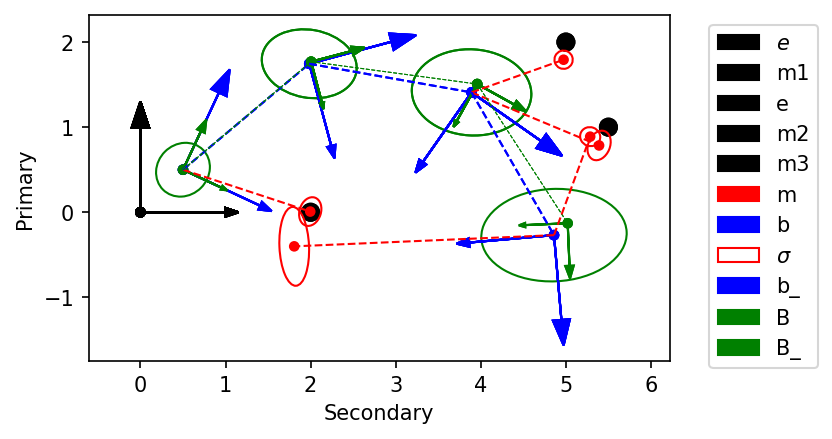

Constructing graph with:
7 nodes
( 4 :poses,  3 :landmark)
8 edge
Edge ['landmark', 0, 0, array([[0.18630505],
       [1.56335052]])]
self.pose[i]   [[0.5       ]
 [0.5       ]
 [0.43633231]]
self.landmark[j]   [[0.00814923]
 [1.99561267]]
self.state_vector[l] [[0.00814923]
 [1.99561267]]
z_il [[0.18630505]
 [1.56335052]]
e_il [[ 2.77555756e-17]
 [-2.22044605e-16]]
A_il [[-0.90630779 -0.42261826  1.56335052]
 [ 0.42261826 -0.90630779 -0.18630505]]
self.bil [[ 0.90630779  0.42261826]
 [-0.42261826  0.90630779]]
Information vector (b)


C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:296: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,0] = -np.sin(X_i.gamma)
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:297: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[1,1] = -np.sin(X_i.gamma)                     # Task
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:298: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,1] = -np.c

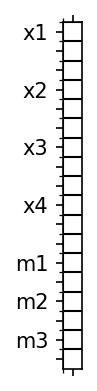

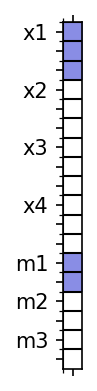

Information matrix (H)


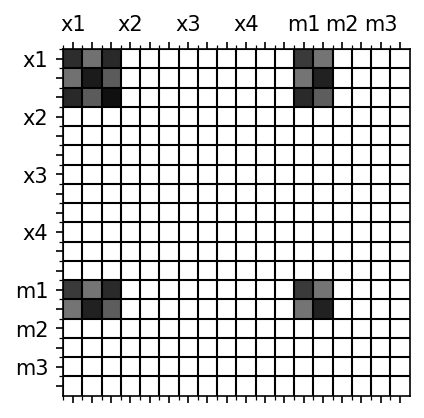

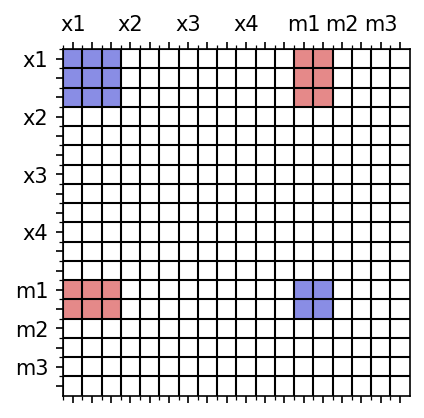

Edge ['motion', 0, 1, array([[1.75564454],
       [0.81867049],
       [0.87266463]])]
e_ij[0:2] [[-8.50480179e-17]
 [-7.13637604e-17]]
(X_i.R.T@(X_j.t-X_i.t) [[1.75564454]
 [0.81867049]]
Z_ij.t [[1.75564454]
 [0.81867049]]
Z_ij.R.T [[ 0.64278761  0.76604444]
 [-0.76604444  0.64278761]]
e_ij[2] [0.]
X_j.gamma,X_i.gamma,Z_ij.gamma [1.30899694] [0.43633231] [0.87266463]
self.pose[i] [[0.5       ]
 [0.5       ]
 [0.43633231]]
self.pose[j] [[1.74516922]
 [1.98393489]
 [1.30899694]]
z_ij [[1.75564454]
 [0.81867049]
 [0.87266463]]
e_ij [[-8.50480179e-17]
 [-7.13637604e-17]
 [ 0.00000000e+00]]
A_ij [[ 0.25881905  0.96592583 -0.81867049]
 [-0.96592583  0.25881905 -1.75564454]
 [ 0.          0.         -1.        ]]
self.bij [[ 0.25881905  0.96592583  0.        ]
 [-0.96592583  0.25881905  0.        ]
 [ 0.          0.          1.        ]]
Information vector (b)


C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:255: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_dg_i[0,0] = -np.sin(X_i.gamma)
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_dg_i[1,1] = -np.sin(X_i.gamma)    # Task
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:257: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_dg_i[0,1] = -np.cos(X_i.gamma)
C:\Use

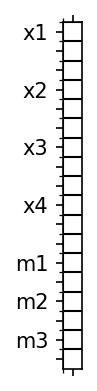

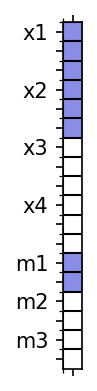

Information matrix (H)


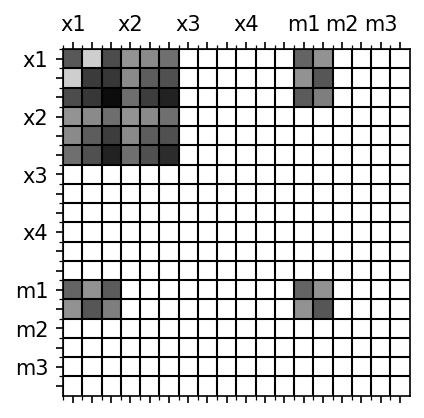

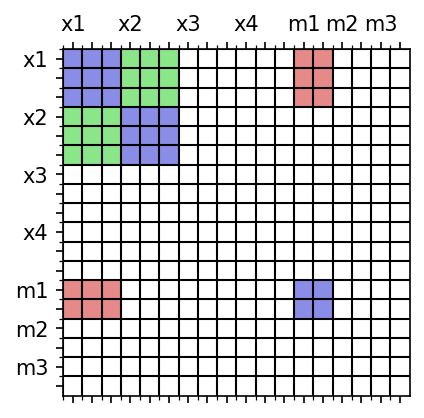

Edge ['motion', 1, 2, array([[1.75564454],
       [0.81867049],
       [0.87266463]])]
e_ij[0:2] [[ 3.70503060e-16]
 [-2.68828311e-16]]
(X_i.R.T@(X_j.t-X_i.t) [[1.75564454]
 [0.81867049]]
Z_ij.t [[1.75564454]
 [0.81867049]]
Z_ij.R.T [[ 0.64278761  0.76604444]
 [-0.76604444  0.64278761]]
e_ij[2] [0.]
X_j.gamma,X_i.gamma,Z_ij.gamma [2.18166156] [1.30899694] [0.87266463]
self.pose[i] [[1.74516922]
 [1.98393489]
 [1.30899694]]
self.pose[j] [[1.40878849]
 [3.89164481]
 [2.18166156]]
z_ij [[1.75564454]
 [0.81867049]
 [0.87266463]]
e_ij [[ 3.70503060e-16]
 [-2.68828311e-16]
 [ 0.00000000e+00]]
A_ij [[-0.57357644  0.81915204 -0.81867049]
 [-0.81915204 -0.57357644 -1.75564454]
 [ 0.          0.         -1.        ]]
self.bij [[-0.57357644  0.81915204  0.        ]
 [-0.81915204 -0.57357644  0.        ]
 [ 0.          0.          1.        ]]
Information vector (b)


C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:255: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_dg_i[0,0] = -np.sin(X_i.gamma)
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_dg_i[1,1] = -np.sin(X_i.gamma)    # Task
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:257: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_dg_i[0,1] = -np.cos(X_i.gamma)
C:\Use

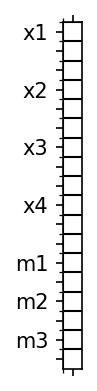

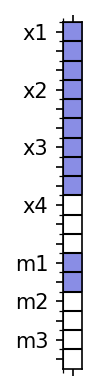

Information matrix (H)


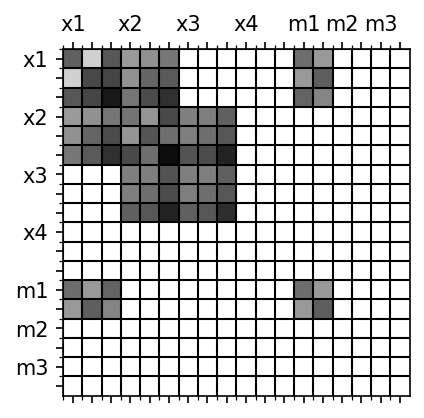

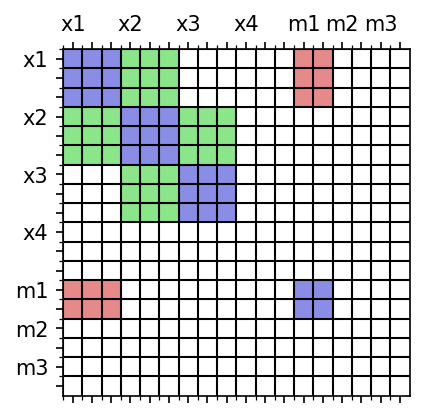

Edge ['landmark', 2, 1, array([[ 0.66552216],
       [-0.9347417 ]])]
self.pose[i]   [[1.40878849]
 [3.89164481]
 [2.18166156]]
self.landmark[j]   [[1.79275623]
 [4.97295446]]
self.state_vector[l] [[1.79275623]
 [4.97295446]]
z_il [[ 0.66552216]
 [-0.9347417 ]]
e_il [[1.11022302e-16]
 [0.00000000e+00]]
A_il [[ 0.57357644 -0.81915204 -0.9347417 ]
 [ 0.81915204  0.57357644 -0.66552216]]
self.bil [[-0.57357644  0.81915204]
 [-0.81915204 -0.57357644]]
Information vector (b)


C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:296: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,0] = -np.sin(X_i.gamma)
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:297: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[1,1] = -np.sin(X_i.gamma)                     # Task
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:298: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,1] = -np.c

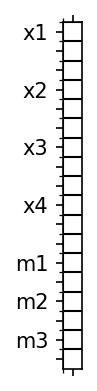

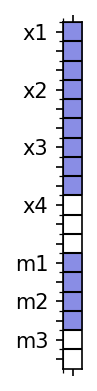

Information matrix (H)


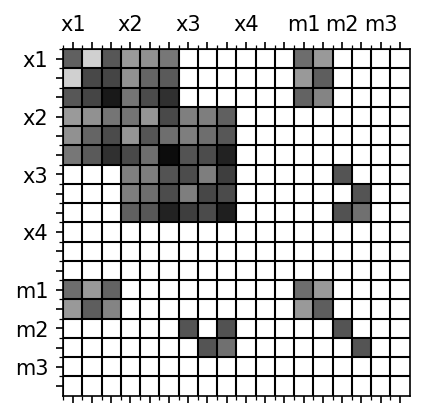

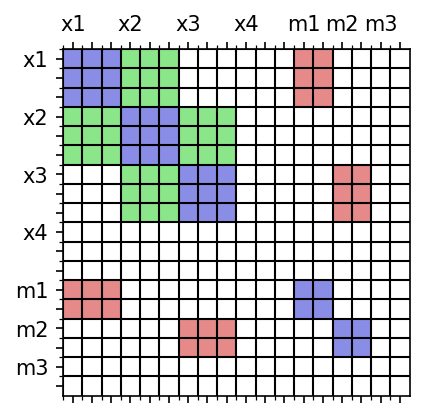

Edge ['landmark', 2, 2, array([[ 1.5852654 ],
       [-0.34866363]])]
self.pose[i]   [[1.40878849]
 [3.89164481]
 [2.18166156]]
self.landmark[j]   [[0.78512614]
 [5.39020344]]
self.state_vector[l] [[0.78512614]
 [5.39020344]]
z_il [[ 1.5852654 ]
 [-0.34866363]]
e_il [[ 2.22044605e-16]
 [-2.77555756e-16]]
A_il [[ 0.57357644 -0.81915204 -0.34866363]
 [ 0.81915204  0.57357644 -1.5852654 ]]
self.bil [[-0.57357644  0.81915204]
 [-0.81915204 -0.57357644]]
Information vector (b)


C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:296: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,0] = -np.sin(X_i.gamma)
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:297: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[1,1] = -np.sin(X_i.gamma)                     # Task
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:298: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,1] = -np.c

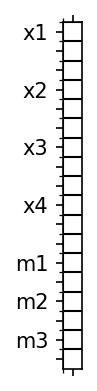

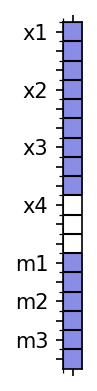

Information matrix (H)


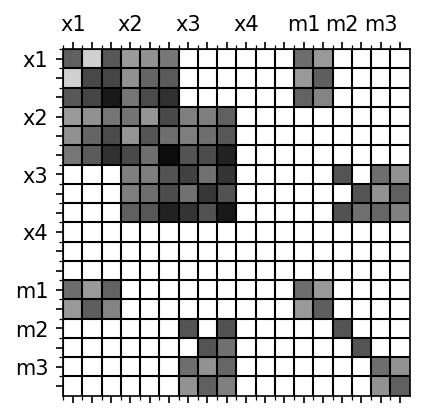

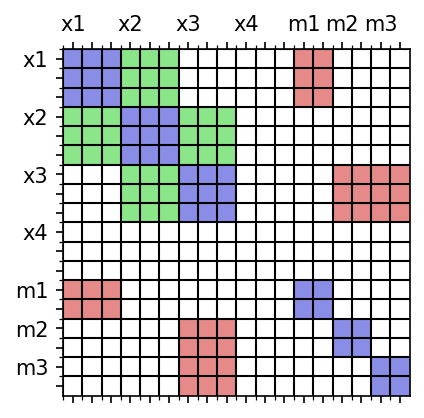

Edge ['motion', 2, 3, array([[1.75564454],
       [0.81867049],
       [0.87266463]])]
e_ij[0:2] [[-8.50480179e-17]
 [-7.13637604e-17]]
(X_i.R.T@(X_j.t-X_i.t) [[1.75564454]
 [0.81867049]]
Z_ij.t [[1.75564454]
 [0.81867049]]
Z_ij.R.T [[ 0.64278761  0.76604444]
 [-0.76604444  0.64278761]]
e_ij[2] [0.]
X_j.gamma,X_i.gamma,Z_ij.gamma [3.05432619] [2.18166156] [0.87266463]
self.pose[i] [[1.40878849]
 [3.89164481]
 [2.18166156]]
self.pose[j] [[-0.26882346]
 [ 4.86021452]
 [ 3.05432619]]
z_ij [[1.75564454]
 [0.81867049]
 [0.87266463]]
e_ij [[-8.50480179e-17]
 [-7.13637604e-17]
 [ 0.00000000e+00]]
A_ij [[-0.9961947   0.08715574 -0.81867049]
 [-0.08715574 -0.9961947  -1.75564454]
 [ 0.          0.         -1.        ]]
self.bij [[-0.9961947   0.08715574  0.        ]
 [-0.08715574 -0.9961947   0.        ]
 [ 0.          0.          1.        ]]
Information vector (b)


C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:255: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_dg_i[0,0] = -np.sin(X_i.gamma)
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_dg_i[1,1] = -np.sin(X_i.gamma)    # Task
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:257: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_dg_i[0,1] = -np.cos(X_i.gamma)
C:\Use

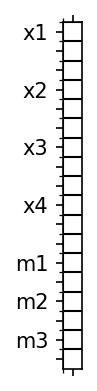

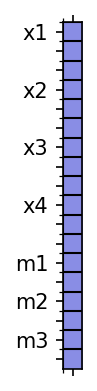

Information matrix (H)


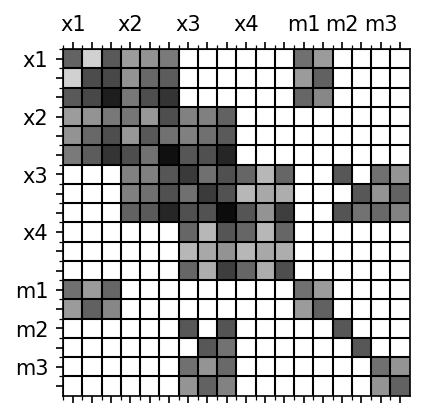

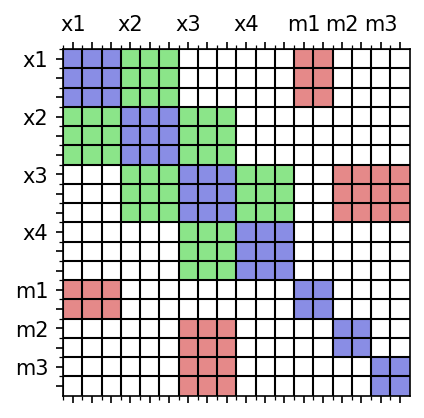

Edge ['landmark', 3, 3, array([[-1.11600297],
       [-0.52457717]])]
e_il [[ 0.11225554]
 [-0.09525275]]
(X_i.R.T@(X_l.t-X_i.t) [[-1.00374742]
 [-0.61982992]]
Z_il.t [[-1.11600297]
 [-0.52457717]]
self.pose[i]   [[-0.26882346]
 [ 4.86021452]
 [ 3.05432619]]
self.landmark[j]   [[0.88865269]
 [5.28552945]]
self.state_vector[l] [[0.78512614]
 [5.39020344]]
z_il [[-1.11600297]
 [-0.52457717]]
e_il [[ 0.11225554]
 [-0.09525275]]
A_il [[ 0.9961947  -0.08715574 -0.61982992]
 [ 0.08715574  0.9961947   1.00374742]]
self.bil [[-0.9961947   0.08715574]
 [-0.08715574 -0.9961947 ]]
Information vector (b)


C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:296: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,0] = -np.sin(X_i.gamma)
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:297: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[1,1] = -np.sin(X_i.gamma)                     # Task
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:298: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,1] = -np.c

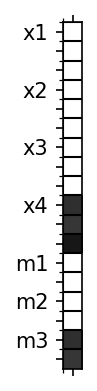

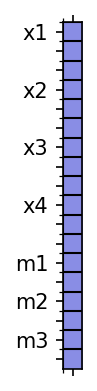

Information matrix (H)


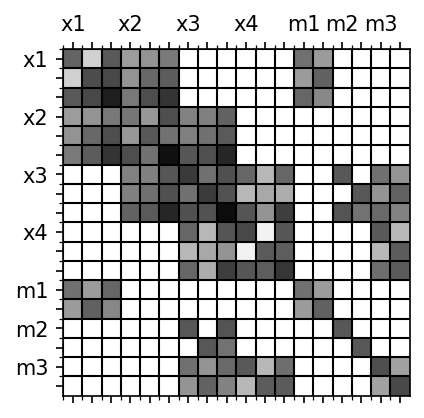

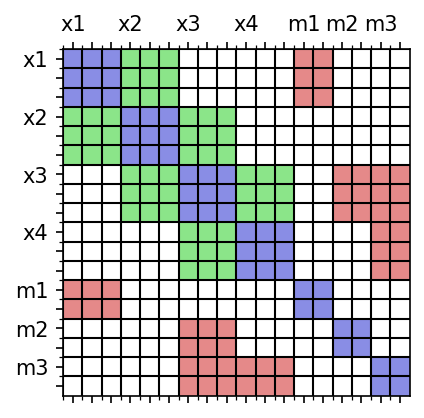

Edge ['landmark', 3, 4, array([[-0.13491235],
       [ 3.05276094]])]
e_il [[-0.39067289]
 [-0.22319953]]
(X_i.R.T@(X_l.t-X_i.t) [[-0.52558523]
 [ 2.82956141]]
Z_il.t [[-0.13491235]
 [ 3.05276094]]
self.pose[i]   [[-0.26882346]
 [ 4.86021452]
 [ 3.05432619]]
self.landmark[j]   [[-0.40049014]
 [ 1.80731187]]
self.state_vector[l] [[0.00814923]
 [1.99561267]]
z_il [[-0.13491235]
 [ 3.05276094]]
e_il [[-0.39067289]
 [-0.22319953]]
A_il [[ 0.9961947  -0.08715574  2.82956141]
 [ 0.08715574  0.9961947   0.52558523]]
self.bil [[-0.9961947   0.08715574]
 [-0.08715574 -0.9961947 ]]
Information vector (b)


C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:296: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,0] = -np.sin(X_i.gamma)
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:297: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[1,1] = -np.sin(X_i.gamma)                     # Task
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:298: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,1] = -np.c

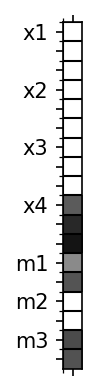

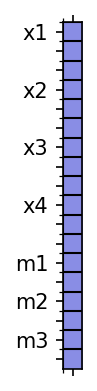

Information matrix (H)


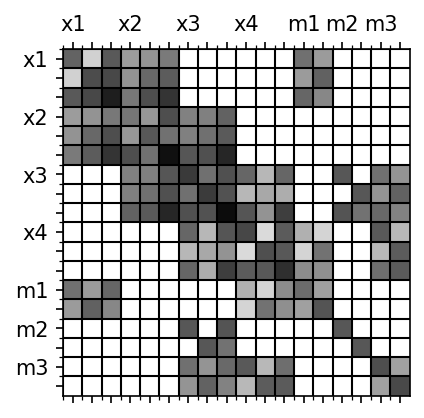

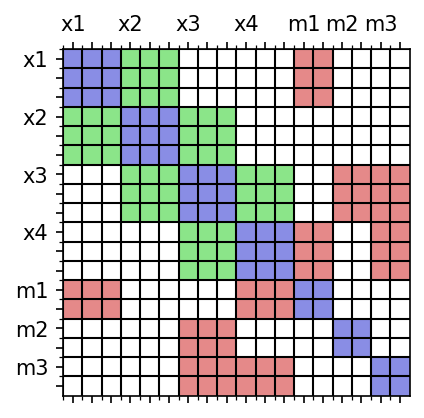

In [12]:
#visualise the spatial constraints
map_ground_truth = [m_e0, m_e1, m_e2]
map_labels = ['m1', 'm2', 'm3']
pose_ground_truth = p_gt_path
plot_graph(graph, pose_ground_truth, H_em, map_ground_truth, map_labels)

#visualise each step of the graph construction
visualise_flag = True
graph.construct_graph(visualise_flag = visualise_flag)

Note the density of the final information matrix constructed using graph SLAM compared to the equivalent covariance matrix that would be needed to solve EKF SLAM.

Original information matrix $\mathbf{H}$)


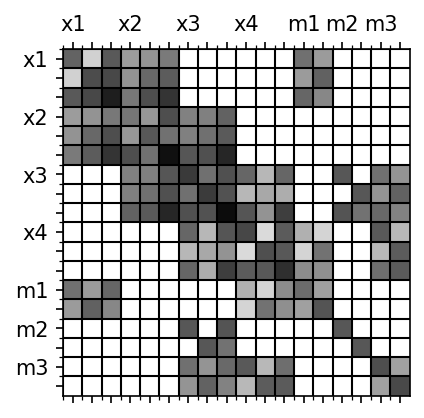

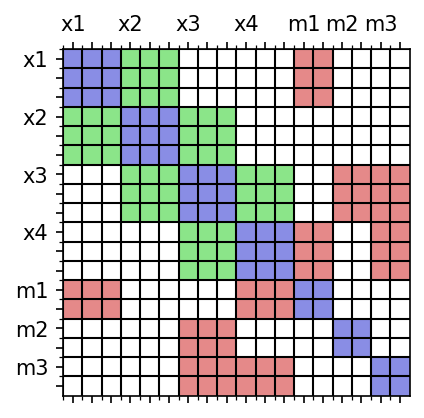

Original covariance matrix $\Sigma$


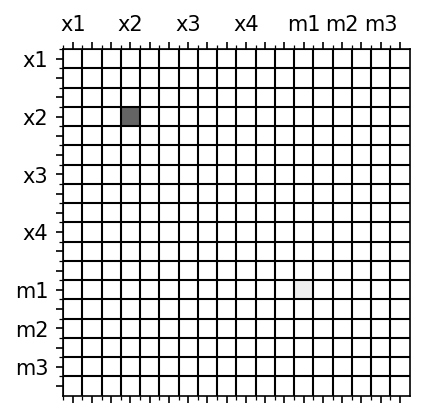

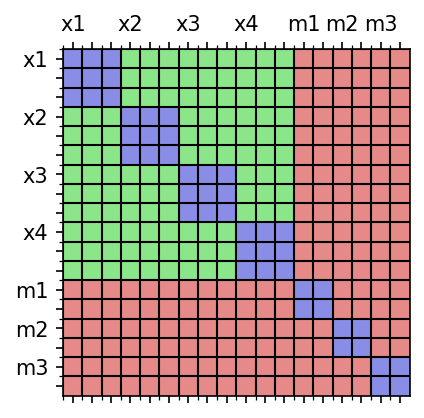

In [13]:
print('Original information matrix $\mathbf{H}$)')        
show_information(graph.H,graph.n,3,graph.m,2)        

print('Original covariance matrix $\Sigma$')        
show_information(Inverse(graph.H),graph.n,3,graph.m,2)        

## 2. Back End

Now that a graph has been constructed, we can optimise it. Note that while the graph construction needed platform and sensor setup/application specific knowledge, the backend is a purely mathematical optimisation that operates on the constructed information vector and matrix.

It implements error minimisation and associated information vector and matrix updates, and also reduction to pose information.

The relevant theory is in B2.2 of the notes, where reduction and optimistation are summerised below.

**Reduction:**

The equivalent information vector $\tilde{\mathbf{b}}$ corresponding to just pose nodes can be obtained as:

\begin{align}
\tilde{\mathbf{H}} &=& \mathbf{H}_{\mathbf{xx}} - \sum_j \mathbf{H}_{\mathbf{xm}_j}\mathbf{H}^{-1}_{\mathbf{m}_j\mathbf{m}_j}\mathbf{H}_{\mathbf{m}_j\mathbf{x}}\\
\tilde{\mathbf{b}} &=& \mathbf{b}_{\mathbf{x}} - \sum_j \mathbf{H}_{\mathbf{x}\mathbf{m}_j}\mathbf{H}^{-1}_{\mathbf{m}_j\mathbf{m}_j}\mathbf{b}_{\mathbf{m}_j}
\end{align}

Note, to reconstruct the full graph, we need to repopulate the information vector using:

\begin{align}
\left(\begin{array}{cc}
\tilde{\mathbf{b}}\\
0 
\end{array}\right)&=&
\left(\begin{array}{c}
\mathbf{b}_{\mathbf{x}}\\
\mathbf{b}_{\mathbf{m}}
\end{array}\right)-\left(\begin{array}{cc}
0 & \mathbf{H}_{\mathbf{x}\mathbf{m}}\mathbf{H}^{-1}_{\mathbf{m}\mathbf{m}}\\
0 & I
\end{array}\right)\left(\begin{array}{c}
\mathbf{b}_{\mathbf{x}}\\
\mathbf{b}_{\mathbf{m}}
\end{array}\right)
\end{align}

**Solving:**

To find the state vector update, the linearised system (or its reduced form) needs to be iteratively solved to produce the optimised pose and map posterior. The relevant equations are: 

\begin{align}
\Delta \mathbf{X}^*&=& -\mathbf{H}^{-1}\mathbf{b}\\
\Delta \mathbf{X}&=&\mathbf{X}^*-\mathbf{X}\\
\end{align}

Or for the reduced form:

\begin{align}
\Delta \mathbf{x}^*&=& -\tilde{\mathbf{H}}^{-1}\tilde{\mathbf{b}}\\
\Delta \mathbf{x}&=&\mathbf{x}^*-\mathbf{x}
\end{align}

Using Cholesky decomposition:
\begin{equation}
\tilde{\mathbf{H}}^{-1} = \mathbf{U}^{-1}(\mathbf{U}^{T})^{-1}, \hspace{1cm} \text{or }\tilde{\mathbf{H}} = \mathbf{U}^{T}\mathbf{U}
\end{equation}

we can solve the necessary inversion as:

\begin{equation}
\tilde{\mathbf{H}}\Delta \mathbf{x} -\tilde{\mathbf{b}}= \mathbf{U}^{T} \underset{\mathbf{v}}{\underbrace{\mathbf{U} \Delta \mathbf{x}}} -\tilde{\mathbf{b}}= \delta_{res.}
\end{equation}

where $\delta_{res.}$ is the residual that we want to make 0. To know how much to change $\Delta \mathbf{x}$ by where we first solve for $\mathbf{v}$:

\begin{equation}
\mathbf{U}^{T} \mathbf{v} = \tilde{\mathbf{b}}
\end{equation}

and then for $\Delta \mathbf{x}$ as:

\begin{equation}
\mathbf{U} \Delta \mathbf{x} = \mathbf{v}
\end{equation}

In [14]:
from scipy.linalg import cholesky
from model_feeg6043 import graphslam_backend

class graphslam_backend:
    """
    This class implements the graph SLAM back end
    
    Functions optimise the graph by:
    - Linearising the graph to the information form
    - Reducing information by transferring loop-closures (i.e., pose-landmark-pose) to pose-pose constrains and eliminating landmarks
    - Optimisation of node positions based on contraint equilibrium
    - Reconstructing the map
    
    Parameters are:
        graph: Graph object constructed using graphslam_frontend

    Functions:            
        _update_nodes(self):
            updates location of nodes in the state vector
        _update_covariance(self):    
            updates the covariances 
        reduce2pose(self, visualise_flag = False):
            shifts information from pose-landmark-pose loop closures to pose-pose
            returns equivalent pose_graph with no landmarks
        solve(self, visualise_flag = False):
            optimises that graph using cholesky decomposition                    
    """
    def __init__(self,graph):
        # Note that the class implementation ONLY stores the translation vector and
        # rotation angle. The rotation matrix and homogeneous transformation matrix are
        # computed on the fly.
        
        self.pose = graph.pose
        self.pose_covariance = graph.pose_covariance
        self.landmark = graph.landmark
        self.landmark_covariance = graph.landmark_covariance
        self.edge = graph.edge          
        self.state_vector = graph.state_vector
        self.pose_id = graph.pose_id
        self.landmark_id_array = graph.landmark_id_array
        self.observation_id = graph.observation_id       
        self.b = graph.b
        self.H = graph.H
        self.sigma_anchor = graph.sigma_anchor
        self.residual = graph.residual
        self.unique_landmark = graph.unique_landmark
        self.sigma = graph.sigma
        self.dx = None
        
        
        self.n = graph.n #number of poses
        self.m = graph.m #number of unique landmarks
        self.e = graph.e #number of edge    
   
    def _update_nodes(self):        
        print('Update nodes')
        self.state_vector += self.dx                
        
        for i in range(self.n+self.m):
            if i<self.n:
                self.pose[i] = self.state_vector[3*i:3*i+3]
            elif i<self.n+self.m:        
                l=(i - self.n)

                landmark_id = self.unique_landmark[l]                
                indices = [index for index, value in enumerate(self.landmark_id_array) if value == landmark_id]

                for i in range(len(indices)):
                    self.landmark[indices[i]] = self.state_vector[l*2+3*self.n:l*2+3*self.n+2]                

    def _update_covariance(self):    
        print('Update covariance')

        for k in range(self.e):
            print('Edge',self.edge[k])

            edge_type=self.edge[k][0]
            i=self.edge[k][1]
            j=self.edge[k][2]    

            if edge_type == 'motion':    
                self.pose_covariance[i]=self.sigma[3*i:3*i+3,3*i:3*i+3]
                self.pose_covariance[j]=self.sigma[3*j:3*j+3,3*j:3*j+3]

            if edge_type == 'landmark':
                l=j
                landmark_id = self.landmark_id_array[l]
                indices = [index for index, value in enumerate(self.landmark_id_array) if value == landmark_id]
                for i in range(len(indices)):
                    self.landmark_covariance[indices[i]]=self.sigma[landmark_id*2+3*self.n:landmark_id*2+3*self.n+2,landmark_id*2+3*self.n:landmark_id*2+3*self.n+2]

    def reduce2pose(self, visualise_flag = False):
        print('Reducing information form to poses only')        
        l = (self.n)*3
        
        sigma_m = Inverse(self.H[l:,l:])
        
        H_ = copy.copy(self.H)
        b_ = copy.copy(self.b)        
        
        ij_mod_k =[]        
        for k in self.unique_landmark:                                    
            ij_mod = []

            for n in range(len(self.edge)):
                if self.edge[n][0] == 'landmark' and self.landmark_id_array[self.edge[n][2]]==k: 
                    ij_mod.append(self.edge[n][1])
                    
            ij_mod_k.append(ij_mod)

            i=ij_mod[0]                                                                          
            H_[i*3:i*3+3,i*3:i*3+3] -= H_[i*3:i*3+3,2*k+l:2*k+l+2]@sigma_m[k*2:k*2+2,k*2:k*2+2]@H_[2*k+l:2*k+l+2,i*3:i*3+3]                                        
            
            if len(ij_mod) > 1:
                j=ij_mod[1]                            
                
                H_[i*3:i*3+3,j*3:j*3+3] -= H_[i*3:i*3+3,2*k+l:2*k+l+2]@sigma_m[k*2:k*2+2,k*2:k*2+2]@H_[2*k+l:2*k+l+2,j*3:j*3+3]    
                H_[j*3:j*3+3,i*3:i*3+3] -= H_[j*3:j*3+3,2*k+l:2*k+l+2]@sigma_m[k*2:k*2+2,k*2:k*2+2]@H_[2*k+l:2*k+l+2,i*3:i*3+3]                        
                H_[j*3:j*3+3,j*3:j*3+3] -= H_[j*3:j*3+3,2*k+l:2*k+l+2]@sigma_m[k*2:k*2+2,k*2:k*2+2]@H_[2*k+l:2*k+l+2,j*3:j*3+3]
                            

        for k in range(len(ij_mod_k)):
            i=ij_mod_k[k][0]                                                                          
                
            b_[i*3:i*3+3] -= H_[i*3:i*3+3,2*k+l:2*k+l+2]@sigma_m[k*2:k*2+2,k*2:k*2+2]@b_[2*k+l:2*k+l+2]            
                        
            if len(ij_mod_k[k]) > 1:
                j=ij_mod_k[k][1]                            
                    
                b_[j*3:j*3+3] -= H_[j*3:j*3+3,2*k+l:2*k+l+2]@sigma_m[k*2:k*2+2,k*2:k*2+2]@b_[2*k+l:2*k+l+2]                            
            
        # remove information on landmarks
        pose_graph = copy.copy(self)  
        pose_graph.state_vector=copy.copy(self.state_vector[0:l])
        pose_graph.landmarks=None
        pose_graph.landmark_id_array=[]
        pose_graph.m=0 #number of landmarks
        pose_graph.e=pose_graph.n-1 #edges =nodes - 1
 
        # update information vector and matrix with those above
        pose_graph.H = copy.copy(H_[:l,:l])
        pose_graph.b = copy.copy(b_[:l])   
                
        
        new_list = []
        for i in range(len(pose_graph.edge)):
            if pose_graph.edge[i][0] == 'motion':
                new_list.append(pose_graph.edge[i])
        pose_graph.edge=new_list
        
        if visualise_flag == True:
            print('Original graph has:')
            print('Poses',self.pose)
            print('Landmarks',self.landmark)
            print('Edges',self.edge)

            print('Information vector (b)')
            show_information(b_,self.n,3,self.m,2)

            print('Information matrix (H)')
            show_information(H_,self.n,3,self.m,2)

            print('Reduced graph has:')
            print('Poses',pose_graph.pose)
            print('Landmarks',pose_graph.landmark)
            print('Edges',pose_graph.edge)

            #need to trim landmarks away also!!
            print('Pose only information vector (b_)')
            show_information(pose_graph.b,pose_graph.n,3,pose_graph.m,2, matrix_compare = self.b[0:self.n*3])        

            print('Pose only Information matrix (H_)')                     
            show_information(pose_graph.H,pose_graph.n,3,pose_graph.m,2, matrix_compare = self.H[0:self.n*3,0:self.n*3])
        
        return pose_graph
        
    def solve(self, recover_sigma = False, visualise_flag = False):
        from datetime import datetime
        print('Solve linear system using Cholesky decomposition')

        cpu_start = datetime.now()
        
        # calculate the upper Cholesky triangle

        self.H = self.H + 0.00001*Identity(len(self.H))
        U = cholesky( self.H, lower=False)          # Task
        
        # Solve a linear system using Cholesky decomposition
        v = np.linalg.solve( U.T , self.b )               # Task
        self.dx = -np.linalg.solve(U, v) # how much we need to shift each node by to minimise the conflict                        # Task
        
        self._update_nodes()  
        
        cpu_end = datetime.now()    

        if recover_sigma == True: self.sigma = Inverse(U) @ Inverse(U.T)    # Task

        self.residual = np.sum(abs(self.dx)/len(self.dx))
        delta =  cpu_end - cpu_start
        
        print('Solver took:',(delta.total_seconds() * 1000),'ms')   

        if visualise_flag == True:
            print('Information vector (b)')
            show_information(self.b,self.n,3,self.m,2)            
            print('Information matrix (H)')
            show_information(self.H,self.n,3,self.m,2)        
            print('Upper Cholesky triangle (U) of Omega.H')
            show_information(U,self.n,3,self.m,2)
            print('Covariance matrix (sigma)')
            show_information(self.sigma,self.n,3,self.m,2)

        print('Residual = ',self.residual) 

## 2.1 Gauss-Newton error minimisation

Next we iteratively solve the graph to find the node configuration that minimises the residual of all edge constraints. 

_Pseudo code_

__optimise($\mathbf{X}$)__ 

$
\begin{array}{lllll}
& \text{while(!converged)} & \\
&  & \mathbf{H},\mathbf{b} = \text{linearise\_around}(\mathbf{X})\\
&  & \tilde{\mathbf{H}},\tilde{\mathbf{b}} = \text{reduce}(\mathbf{H},\mathbf{b})\\
&  & \Delta \mathbf{x} = \text{solve\_sparse}(\tilde{\mathbf{H}}\Delta \mathbf{x}=-\tilde{\mathbf{b}})\\
&  & \mathbf{x} =  \mathbf{x} + \Delta \mathbf{x}\\
&  & \text{if } \sum \Delta \mathbf{x} < \text{threshold: converged=True}\\
&  \tilde{\boldsymbol{\Sigma}} = \tilde{\mathbf{H}}^{-1}\\
& \text{return }\mathbf{x},\tilde{\boldsymbol{\Sigma}} & \\                  
\end{array}
$

Solve linear system using Cholesky decomposition
Update nodes
Solver took: 0.0 ms
Residual =  0.04248053714912677
**************  Residual =  0.04248053714912677  ***************
Residual above threshold? True
************** Iteration =  1  ***************
Iterations below limit? True
********* Delta Residual =  0.9995751946285086  ***************
Residual still changing? True
Constructing graph with:
7 nodes
( 4 :poses,  3 :landmark)
8 edge
Solve linear system using Cholesky decomposition
Update nodes
Solver took: 0.0 ms
Residual =  0.035225234050884964
**************  Residual =  0.035225234050884964  ***************
Residual above threshold? True
************** Iteration =  2  ***************
Iterations below limit? True
********* Delta Residual =  0.1707912278221027  ***************
Residual still changing? True
Constructing graph with:
7 nodes
( 4 :poses,  3 :landmark)
8 edge
Solve linear system using Cholesky decomposition
Update nodes
Solver took: 1.423 ms
Residual =  0.06294637

C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:296: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,0] = -np.sin(X_i.gamma)
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:297: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[1,1] = -np.sin(X_i.gamma)                     # Task
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:298: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,1] = -np.c

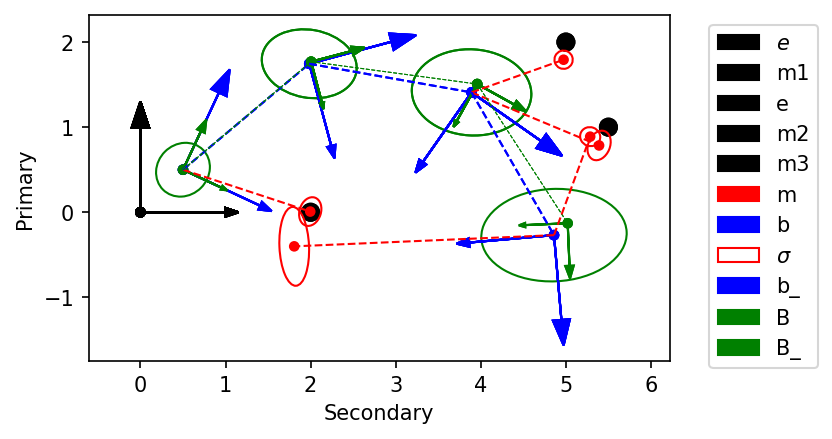

Optimised


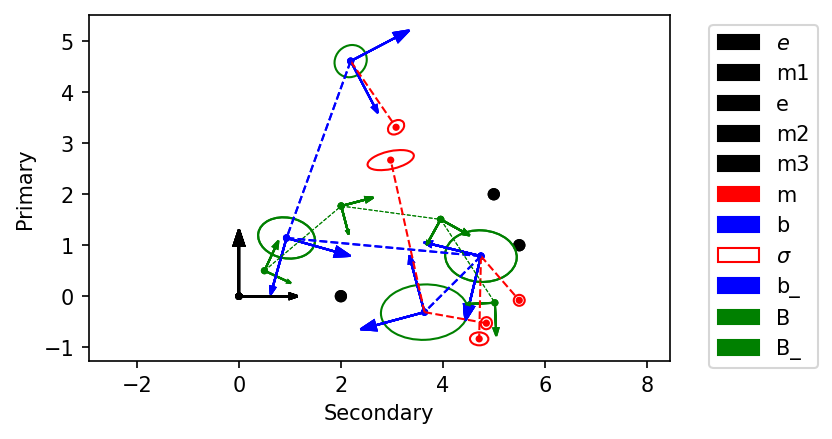

In [15]:
from datetime import datetime

initial_residual = 100 #just needs to be a big number to avoid triggering convergence if the first iteration has large residuals
initial_flag = True

residual_threshold = 1E-12 #if result changes by <1
delta_threshold = 1/10 #if result changes by <1
lim_iterations = 20

n_iterations = 0
delta_residual = initial_residual
residual = initial_residual

visualise_flag = False
iteration_continue = True 
residual_continue = True
converge_continue = True

# if any of the conditions become false, then while loop will exit
cpu_start_solver = datetime.now()


graph_init = copy.deepcopy(graph)
graph_validate = copy.deepcopy(graph)
graph_opt = graphslam_backend(graph)

while iteration_continue and residual_continue and converge_continue:    
    graph_opt.solve()
    
    prev_residual = residual
    residual = graph_opt.residual

    delta_residual = abs((prev_residual - residual) /prev_residual)
    n_iterations += 1

    print('**************  Residual = ',residual,' ***************')        
    residual_continue = (residual > residual_threshold)
    print('Residual above threshold?',residual_continue)    
    
    print('************** Iteration = ',n_iterations,' ***************')
    iteration_continue = (n_iterations <= lim_iterations)
    print('Iterations below limit?',iteration_continue)
    
    print('********* Delta Residual = ',delta_residual,' ***************')
    converge_continue = (delta_residual > delta_threshold)
    print('Residual still changing?',converge_continue)
    
    #reconstruct the graph with these nodes
    graph_opt = graphslam_frontend( graph_opt )   # Task
    graph_opt.construct_graph(  ) # Task
    graph_opt = graphslam_backend( graph_opt )    # Task
    
    
cpu_end_solver = datetime.now()
delta =  cpu_end_solver - cpu_start_solver       
print('********* Final solution took:',(delta.total_seconds()),'s ***************')   

#plot the resulting graph
print('Original')
plot_graph(graph_validate, pose_ground_truth, H_em, map_ground_truth, map_labels)
print('Optimised')
plot_graph(graph_opt, pose_ground_truth, H_em, map_ground_truth, map_labels)

## 2.2 Reduction to poses and re-mapping (optional, for efficiency gains)

The SLAM backend can optimise the full graph, but equivalent results can be achieved by reducing to just poses and transfering information from observation loop closures to between poses. For large graphs, this can improve computational efficiency. The graph reduction process itself requires some computation itself and so it does not always speed things up.

Original graph has:
Poses 4
Landmarks 3
Edges 8


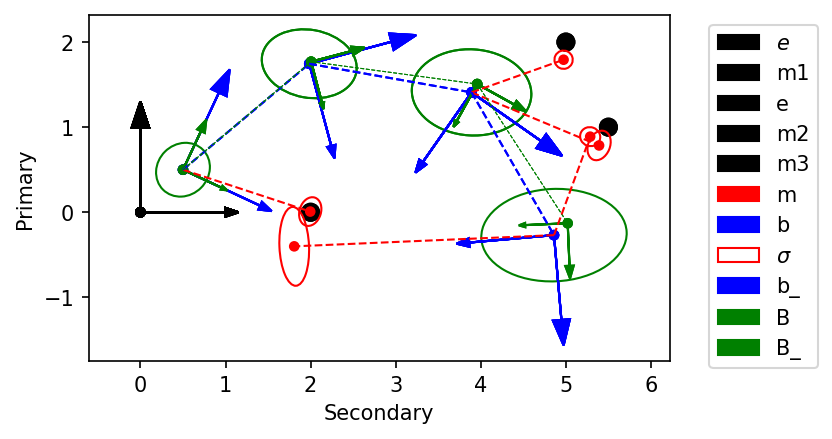

Reducing information form to poses only
Reduced graph has:
Poses 4
Landmarks 0
Edges 3


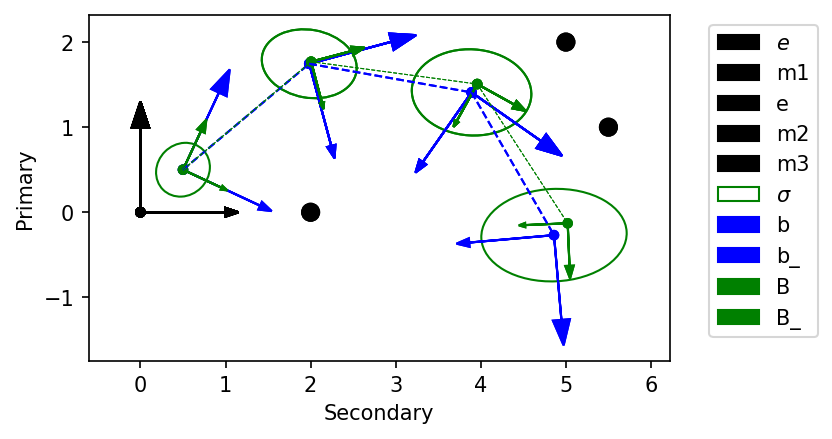

Reducing information form to poses only
Original graph has:
Poses [array([[0.5       ],
       [0.5       ],
       [0.43633231]]), array([[1.74516922],
       [1.98393489],
       [1.30899694]]), array([[1.40878849],
       [3.89164481],
       [2.18166156]]), array([[-0.26882346],
       [ 4.86021452],
       [ 3.05432619]])]
Landmarks [array([[0.00814923],
       [1.99561267]]), array([[1.79275623],
       [4.97295446]]), array([[0.78512614],
       [5.39020344]]), array([[0.88865269],
       [5.28552945]]), array([[-0.40049014],
       [ 1.80731187]])]
Edges [['landmark', 0, 0, array([[0.18630505],
       [1.56335052]])], ['motion', 0, 1, array([[1.75564454],
       [0.81867049],
       [0.87266463]])], ['motion', 1, 2, array([[1.75564454],
       [0.81867049],
       [0.87266463]])], ['landmark', 2, 1, array([[ 0.66552216],
       [-0.9347417 ]])], ['landmark', 2, 2, array([[ 1.5852654 ],
       [-0.34866363]])], ['motion', 2, 3, array([[1.75564454],
       [0.81867049],
       [0

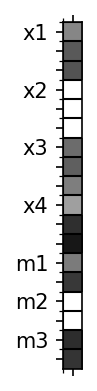

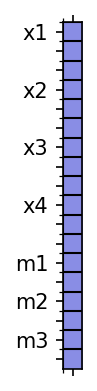

Information matrix (H)


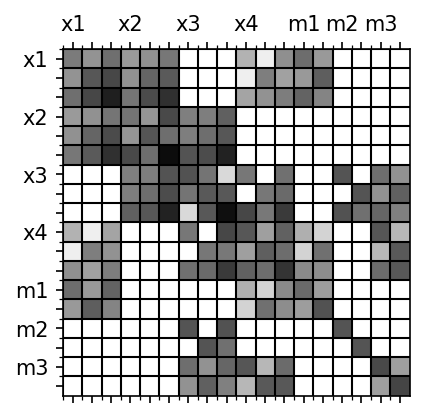

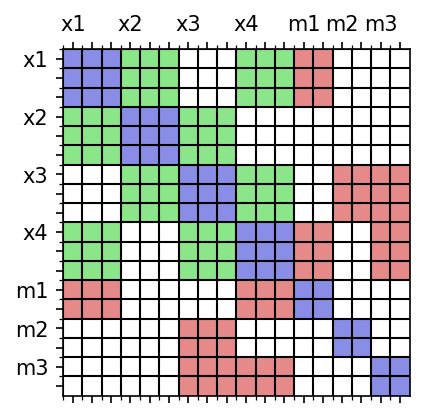

Reduced graph has:
Poses [array([[0.5       ],
       [0.5       ],
       [0.43633231]]), array([[1.74516922],
       [1.98393489],
       [1.30899694]]), array([[1.40878849],
       [3.89164481],
       [2.18166156]]), array([[-0.26882346],
       [ 4.86021452],
       [ 3.05432619]])]
Landmarks [array([[0.00814923],
       [1.99561267]]), array([[1.79275623],
       [4.97295446]]), array([[0.78512614],
       [5.39020344]]), array([[0.88865269],
       [5.28552945]]), array([[-0.40049014],
       [ 1.80731187]])]
Edges [['motion', 0, 1, array([[1.75564454],
       [0.81867049],
       [0.87266463]])], ['motion', 1, 2, array([[1.75564454],
       [0.81867049],
       [0.87266463]])], ['motion', 2, 3, array([[1.75564454],
       [0.81867049],
       [0.87266463]])]]
Pose only information vector (b_)


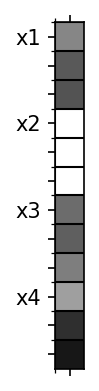

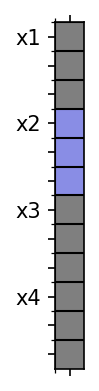

Pose only Information matrix (H_)


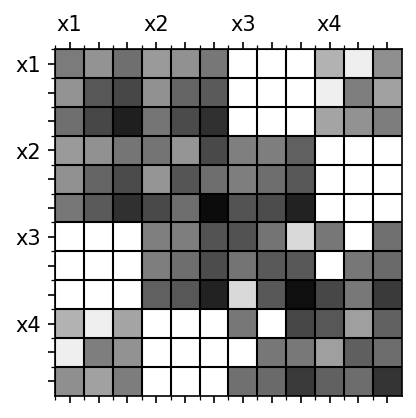

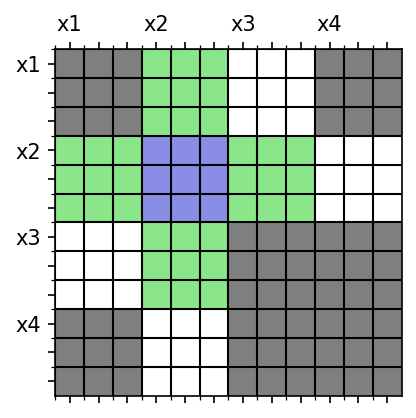

Grey cells indicate information that has been modified through the graph reduction


In [16]:
#show the original graph
graph_opt = graphslam_backend(graph_init)
print('Original graph has:')
print('Poses',graph_init.n)
print('Landmarks',graph_init.m)
print('Edges',graph_init.e)

plot_graph(graph_opt, pose_ground_truth, H_em, map_ground_truth, map_labels)

#show the reduced form
pose_graph = graph_opt.reduce2pose()
print('Reduced graph has:')
print('Poses',pose_graph.n)
print('Landmarks',pose_graph.m)
print('Edges',pose_graph.e)

plot_graph(pose_graph, pose_ground_truth, H_em, map_ground_truth, map_labels)

# shows information vector and matrix
visualise_flag = True 
pose_graph = graph_opt.reduce2pose(visualise_flag)
print('Grey cells indicate information that has been modified through the graph reduction')

Reducing information form to poses only
Solve linear system using Cholesky decomposition
Update nodes
Solver took: 0.0 ms
Residual =  0.03896602792459473
**************  Residual =  0.03896602792459473  ***************
Residual above threshold? True
************** Iteration =  1  ***************
Iterations below limit? True
********* Delta Residual =  0.999610339720754  ***************
Residual still changing? True
Constructing graph with:
7 nodes
( 4 :poses,  3 :landmark)
8 edge
Reducing information form to poses only
Solve linear system using Cholesky decomposition
Update nodes
Solver took: 0.0 ms
Residual =  0.03990138746925495
**************  Residual =  0.03990138746925495  ***************
Residual above threshold? True
************** Iteration =  2  ***************
Iterations below limit? True
********* Delta Residual =  0.024004487870056664  ***************
Residual still changing? True
Constructing graph with:
7 nodes
( 4 :poses,  3 :landmark)
8 edge
Reducing information form t

C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:296: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,0] = -np.sin(X_i.gamma)
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:297: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[1,1] = -np.sin(X_i.gamma)                     # Task
C:\Users\skyem\AppData\Local\Temp\ipykernel_19168\2009590637.py:298: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dR_i_d_g_i[0,1] = -np.c

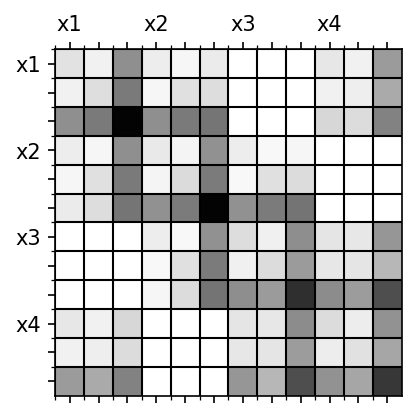

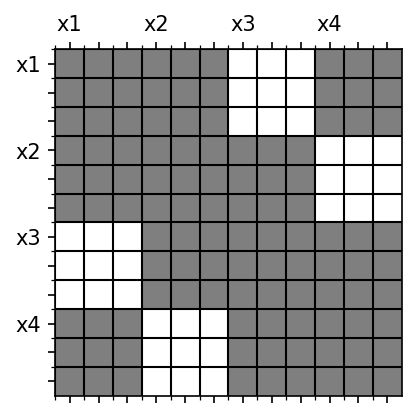

********* Final solution took: 0.020061 s ***************


In [17]:
initial_residual = 100 #just needs to be a big number to avoid triggering convergence if the first iteration has large residuals
initial_flag = True

residual_threshold = 1E-12 #if result changes by <1
delta_threshold = 1/1000 #if result changes by <1
lim_iterations = 20

n_iterations = 0
delta_residual = initial_residual
residual = initial_residual

visualise_flag = False
iteration_continue = True 
residual_continue = True
converge_continue = True

# reset the pose graph (full_graph_ should be unaffected by previous calculations)
pose_graph = graph_opt.reduce2pose(visualise_flag)
l = graph_opt.n*3

# if any of the conditions become false, then while loop will exit
cpu_start_solver = datetime.now()

while iteration_continue and residual_continue and converge_continue:
    
    pose_graph.solve()    
    
    prev_residual = residual
    residual = pose_graph.residual

    delta_residual = abs((prev_residual - residual) /prev_residual)
    n_iterations += 1

    print('**************  Residual = ',residual,' ***************')        
    residual_continue = (residual > residual_threshold)
    print('Residual above threshold?',residual_continue)    
    
    print('************** Iteration = ',n_iterations,' ***************')
    iteration_continue = (n_iterations <= lim_iterations)
    print('Iterations below limit?',iteration_continue)
    
    print('********* Delta Residual = ',delta_residual,' ***************')
    converge_continue = (delta_residual > delta_threshold)
    print('Residual still changing?',converge_continue)

    #reconstruct the graph with these nodes
    graph_opt.state_vector[0:l] = pose_graph.state_vector # Task
    graph_opt.state_vector[l:] = Inverse(graph_opt.H[l:,l:])@(graph_opt.b[l:]+graph_opt.H[l:,0:l]@graph_opt.state_vector[0:l])
    graph_opt = graphslam_frontend(graph_opt)
    graph_opt.construct_graph()
    graph_opt = graphslam_backend(graph_opt) 
    
    pose_graph = graph_opt.reduce2pose(visualise_flag)

cpu_end_solver = datetime.now()

show_information(pose_graph.H,pose_graph.n,3,pose_graph.m,2, matrix_compare = graph_init.H[0:l,0:l])
    

delta =  cpu_end_solver - cpu_start_solver
print('********* Final solution took:',(delta.total_seconds()),'s ***************')                                                                

Where line 48 makes use of:

\begin{align}
\left(\begin{array}{cc}
\tilde{\mathbf{b}}\\
0 
\end{array}\right)&=&
\left(\begin{array}{c}
\mathbf{b}_{\mathbf{x}}\\
\mathbf{b}_{\mathbf{m}}
\end{array}\right)-\left(\begin{array}{cc}
0 & \mathbf{H}_{\mathbf{x}\mathbf{m}}\mathbf{H}^{-1}_{\mathbf{m}\mathbf{m}}\\
0 & I
\end{array}\right)\left(\begin{array}{c}
\mathbf{b}_{\mathbf{x}}\\
\mathbf{b}_{\mathbf{m}}
\end{array}\right)
\end{align}

to recover $\mathbf{b}_m$

For small graphSLAM problems, the computational overhead of reducing the graph may cancel any advantage of faster optimisation of the smaller pose graph, but as the SLAM problems increase in size, the efficiency gains begin to outweigh the reduction computation.

Below we plot the results of the optimised pose-graph and reconstructed landmark measurements. Poses in both results are identical and more self consistant that the original graph.

Optimised pose graph


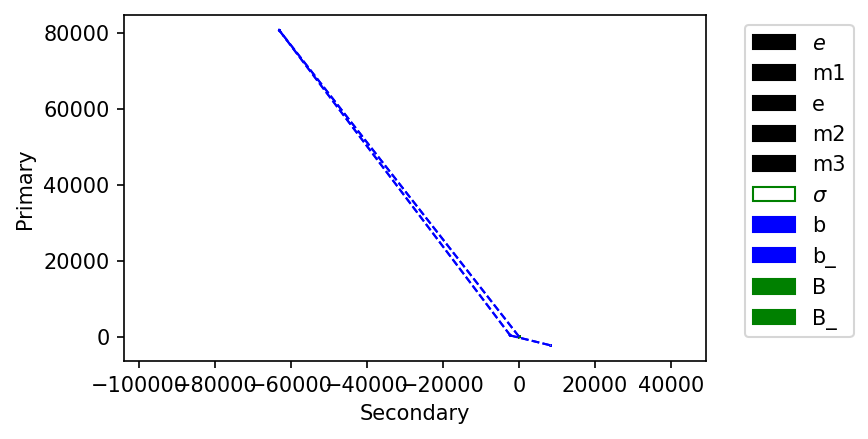

Reconstructed landmarks from optimised pose graph


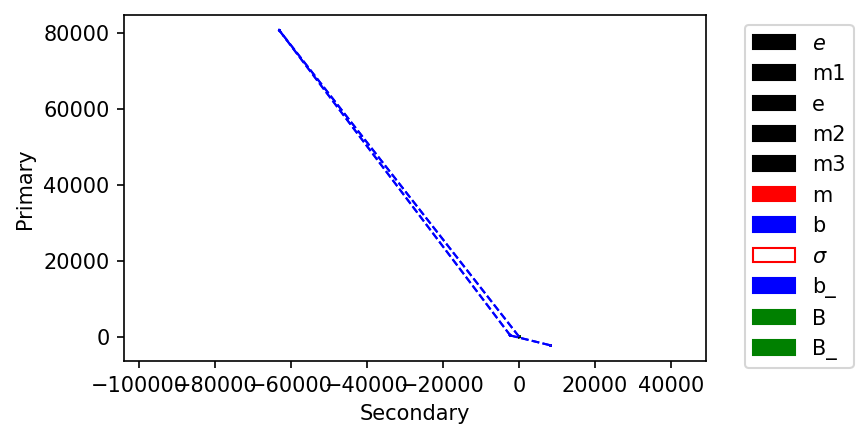

Original


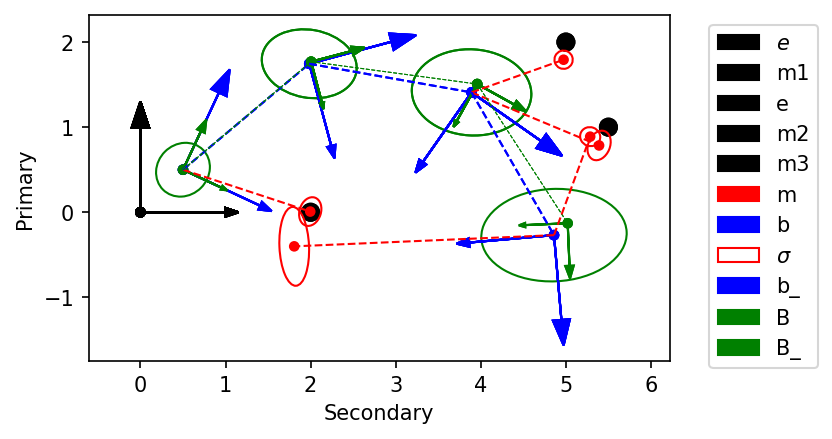

In [18]:
#establish the updates pose and regenerates the map
print('Optimised pose graph')
plot_graph(pose_graph, pose_ground_truth, H_em, map_ground_truth, map_labels)
print('Reconstructed landmarks from optimised pose graph')
plot_graph(graph_opt, pose_ground_truth, H_em, map_ground_truth, map_labels)
print('Original')
plot_graph(graph_validate, pose_ground_truth, H_em, map_ground_truth, map_labels)

## <span style="color:green">Wrapup</span>
    
You should now understand how graph SLAM optimises full robot paths using feature-based maps, including
- Front-end: Construction of pose-graphs and information matrices from robotic motion and observations
- Back-end: Optimisation of the graph together with methods for increased computational efficiency

The front end requires application knowledge, but backend libraries generalise to any robotic problems. The libraries developed here can apply to small robotic problems. While you are welcome to use them in your assignment, you may also want to consider using a library like g2o-python (see section C3) that is designed to handle large scale SLAM problems.